# Import and Dataset


In [ ]:
!pip install kaggle

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
from scipy.stats import randint, ttest_ind, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import gc
import re
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

import warnings
warnings.filterwarnings('ignore')

**Please upload your kaggle.json file.**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"waralakpariwatphan","key":"3b4d578dab492004f443bd12da627886"}'}

In [ ]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -l ~/.kaggle

!mkdir kaggle
!kaggle competitions download -c home-credit-default-risk
!unzip -q home-credit-default-risk.zip -d kaggle/dataset/

total 4
-rw------- 1 root root 74 Mar 29 09:31 kaggle.json
100% 688M/688M [00:19<00:00, 36.1MB/s]
100% 688M/688M [00:19<00:00, 37.3MB/s]


**To get description for each column if needed.**

In [ ]:
description = pd.read_csv('/content/kaggle/dataset/HomeCredit_columns_description.csv', encoding='latin-1').drop(columns='Unnamed: 0')

def get_def(table_name, column_name):
    if table_name in ['application_train', 'application_test']:
        table_name = 'application_{train|test}.csv'
    else:
        table_name = str(table_name)+'.csv'
    des = description[(description['Table'] == table_name)&(description['Row'] == column_name)]['Description'].values
    note = description[(description['Table'] == table_name)&(description['Row'] == column_name)]['Special'].values
    for des_def in des:
        print(des_def)
    for special in note:
        print(special)

# EDA, Missing Values, and Features

## Overview

**Data Quality**

The dataset seems to be satisfied in data quality but there are some issues that need to be addressed:

*   There are some missing values in the dataset that need to be handled properly. Depending on the type of missing data, appropriate techniques such as imputation (with mean/mode) or deletion will be applied.
*   The data types for each column are consistent but there are some inconsistencies in the data itself, for example, a single woman with 19 children. These outliers need to be identified and fixed.

**Data Insights**

During the the modeling session, the model highlighted some interesting features that were suggested by all models during the fine-tune parameters stage. The important features that were identified include *EXT_SOURCE_3*, *EXT_SOURCE_2*, and *AMT_DEBT_PER_CREDIT*. It is worth noting that the first two features are the normalized scores obtained from external data sources and from EDA stage, lower score has more default risk, while *AMT_DEBT_PER_CREDIT* refers to the total amount of debt per credit by bureau which more debt per credit might lead to more risk.

Moreover, there are some interesting features related to the personal information of borrowers, for example, *AGE*: younger borrowers are at a higher risk of default,  additionally, *NAME_EDUCATION_TYPE*: borrowers with higher education levels have a lower default risk.

For more information about the features, you can refer to the EDA section for each type of feature. There, you will find the steps to test the relevance of the features with the target. For categorical columns, the Chi-square test of independence is used to check if there is a significant difference between the target and the feature. For numerical columns, T-test is used to check if there is a significant difference in means between two groups. Additionally, some exploration with plots and summary tables is also performed.




## EDA for categorical features

In [ ]:
# Main dataset
application_train = pd.read_csv('/content/kaggle/dataset/application_train.csv')
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
application_train.shape

(307511, 122)

Data is imbalanced.

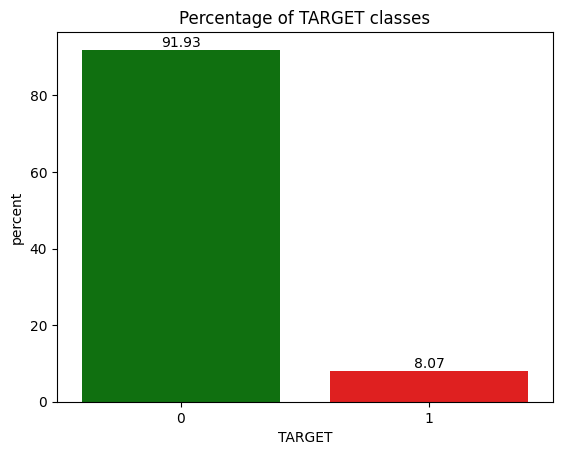

In [ ]:
ax = sns.countplot(application_train, x="TARGET", stat="percent", palette=['g', 'r'])
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.title('Percentage of TARGET classes');

In [ ]:
num_cols = application_train.select_dtypes(include='number').columns.tolist()
cat_cols = application_train.select_dtypes(include='object').columns.tolist()

# Missing values in categorical features
(application_train[cat_cols].isnull().sum())/(application_train.shape[0])

NAME_CONTRACT_TYPE            0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
FLAG_OWN_REALTY               0.000000
NAME_TYPE_SUITE               0.004201
NAME_INCOME_TYPE              0.000000
NAME_EDUCATION_TYPE           0.000000
NAME_FAMILY_STATUS            0.000000
NAME_HOUSING_TYPE             0.000000
OCCUPATION_TYPE               0.313455
WEEKDAY_APPR_PROCESS_START    0.000000
ORGANIZATION_TYPE             0.000000
FONDKAPREMONT_MODE            0.683862
HOUSETYPE_MODE                0.501761
WALLSMATERIAL_MODE            0.508408
EMERGENCYSTATE_MODE           0.473983
dtype: float64

**Chi-square test of independence**

In [ ]:
chi2_ls = []
pval_ls = []
for col in cat_cols:
    tab = pd.crosstab(application_train[col], application_train['TARGET'])
    chi2, p_val, _, _ = chi2_contingency(tab)
    chi2_ls.append(chi2)
    pval_ls.append(p_val)

pd_cats_chi2 = pd.DataFrame({'Column name': cat_cols, 'Chi-square': chi2_ls, 'P-value': pval_ls})
pd_cats_chi2['Reject H0'] = pd_cats_chi2['P-value'] < 0.05
pd_cats_chi2

,Column name,Chi-square,P-value,Reject H0
0,NAME_CONTRACT_TYPE,293.150542,1.023515e-65,True
1,CODE_GENDER,920.791334,1.129022e-200,True
2,FLAG_OWN_CAR,146.656018,9.330994e-34,True
3,FLAG_OWN_REALTY,11.575827,6.681470e-04,True
4,NAME_TYPE_SUITE,32.825315,1.132931e-05,True
5,NAME_INCOME_TYPE,1253.470808,1.928146e-266,True
6,NAME_EDUCATION_TYPE,1019.213187,2.447681e-219,True
7,NAME_FAMILY_STATUS,504.694083,7.744842e-107,True
8,NAME_HOUSING_TYPE,420.556190,1.099089e-88,True
9,OCCUPATION_TYPE,1402.846796,3.784500e-288,True


From the chi-square test of independence, there is an association between each variable in categorical features and target class at significance level 0.05.

In [ ]:
def plot_cat(table, col):
    col_ls = [col, 'TARGET']
    df = table[col_ls]
    g = sns.catplot(data=df, x=col, hue="TARGET", kind="count", col="TARGET", stat="percent", height=4)
    for ax in g.axes.flat:
        # ls_target = []
        for p in ax.patches:
            # ls_target.append(p.get_height())
            if p.get_height() != 0:
                ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', size=7)
        # print(ls_target)
    x_labels = [label.get_text() for label in ax.get_xticklabels()]
    # print(x_labels)

    g.set_axis_labels(col, "Percentage")
    g.set_xticklabels(rotation=90, size=8)
    plt.show()

From the below plots, there are some interesting findings when comparing the proportion of defaults in TARGET=0 and TARGET=1 for each group

Column name | Note
--- | ---
NAME_CONTRACT_TYPE | Revolving loan seems to have less default risk.
CODE_GENDER | Female seems to have less default risk.
FLAG_OWN_CAR | Having own car seems to have less default risk.
FLAG_OWN_REALTY | Having own realty seems to have less default risk.
NAME_TYPE_SUITE | Other_A seems to have less default risk and Group of people seems to have more default risk.
NAME_INCOME_TYPE | Pensioner seems to have less default risk and working group seems to have more default risk.
NAME_EDUCATION_TYPE | Higher education group seems to have less default risk and lower secondary group seems to have more default risk.
NAME_FAMILY_STATUS | Widow group seems to have less default risk and civil marriage group seems to have more default risk.
NAME_HOUSING_TYPE | Office apartment group seems to have less default risk and rented apartment group seems to have more default risk.
OCCUPATION_TYPE | Accountant group seems to have less default risk and low-skill laborer group seems to have more default risk.
WEEKDAY_APPR_PROCESS_START | Each group has not much different, anyway, Monday group seems to have less default risk and Tuesday laborer group seems to have more default risk.
ORGANIZATION_TYPE | Trade: type 4 group seems to have less default risk and Transport: type 3 group seems to have more default risk.
FONDKAPREMONT_MODE | Org spec account group seems to have less default risk and not specified group seems to have more default risk.
HOUSETYPE_MODE | Block of flats group seems to have less default risk and specific housing group seems to have more default risk.
WALLSMATERIAL_MODE | Monolithic group seems to have less default risk and Wooden group seems to have more default risk.
EMERGENCYSTATE_MODE | Not emergency seems to have less default risk.






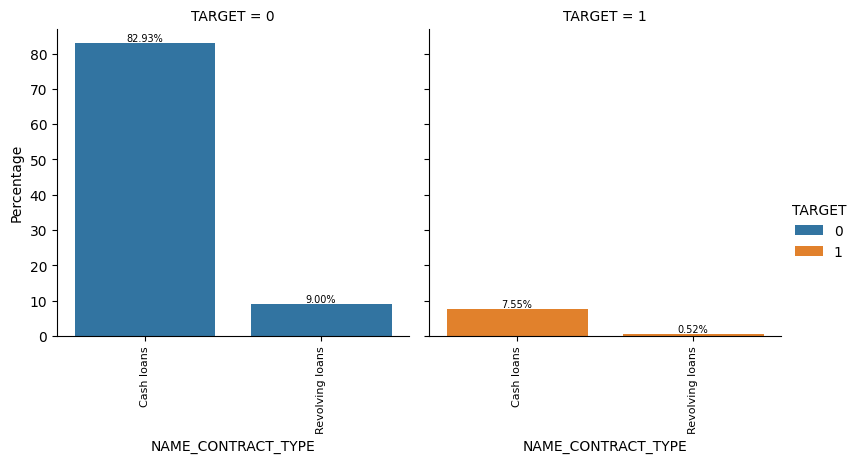

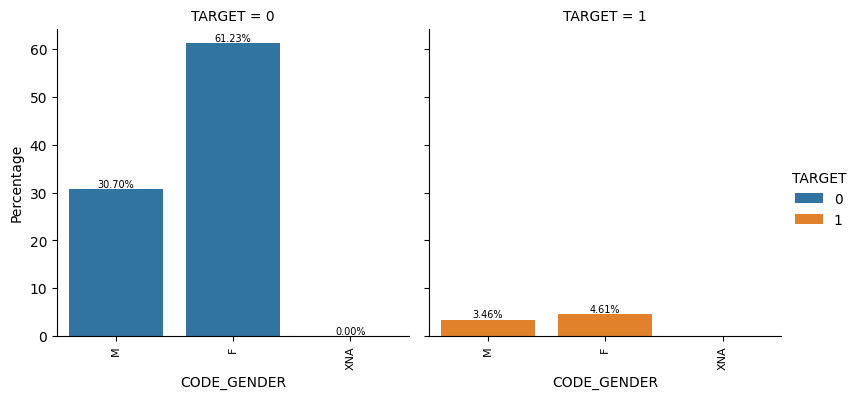

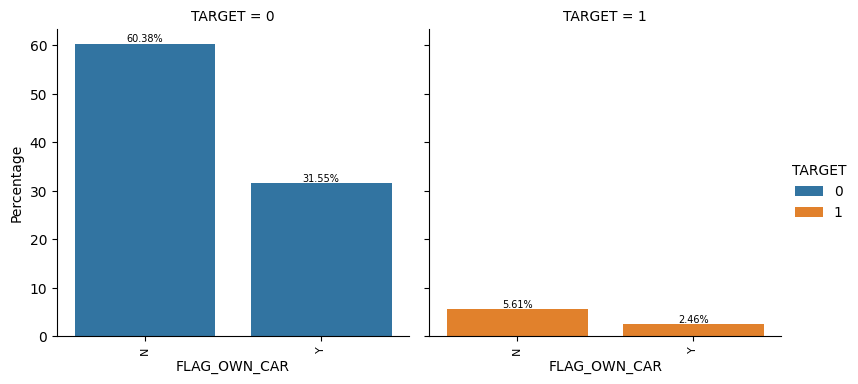

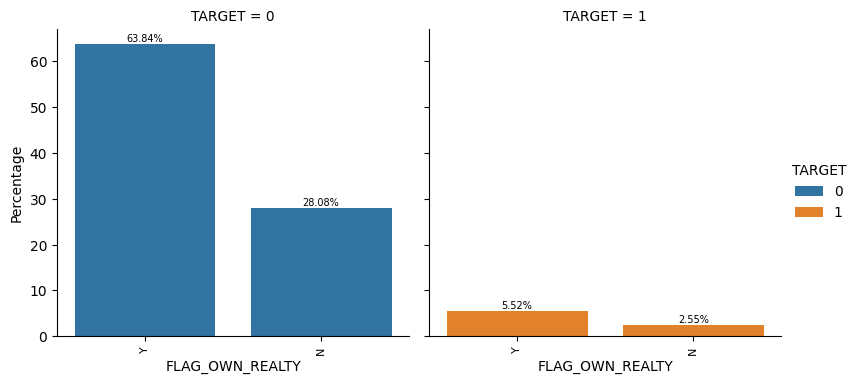

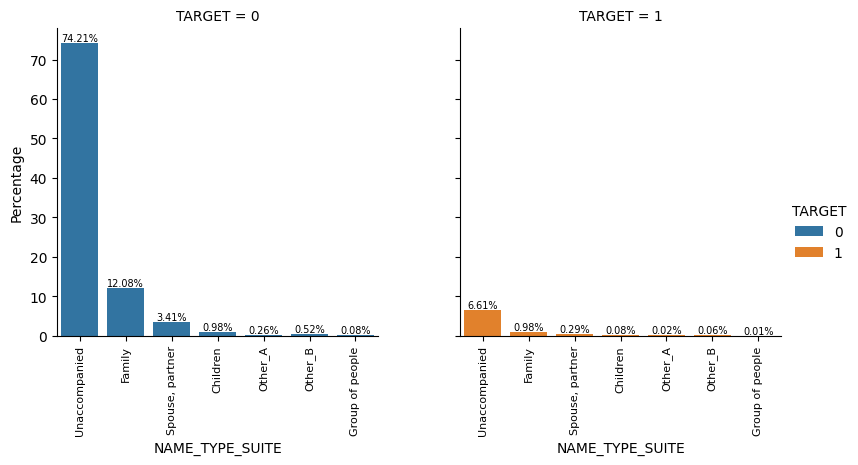

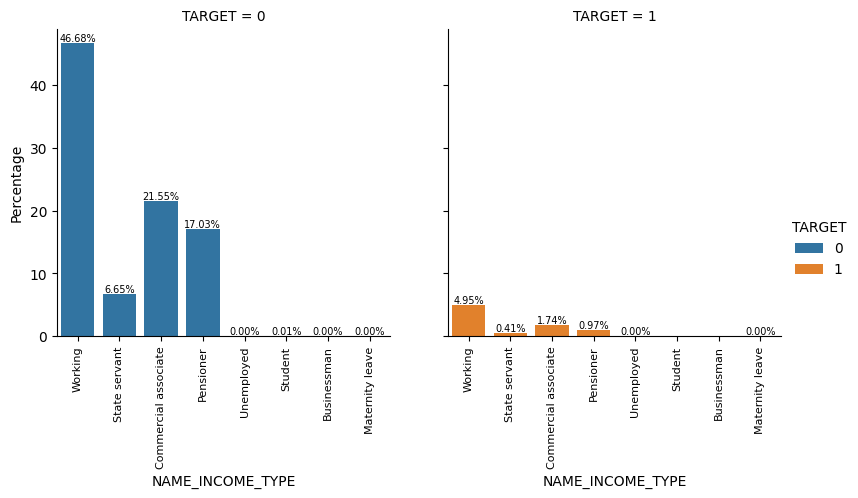

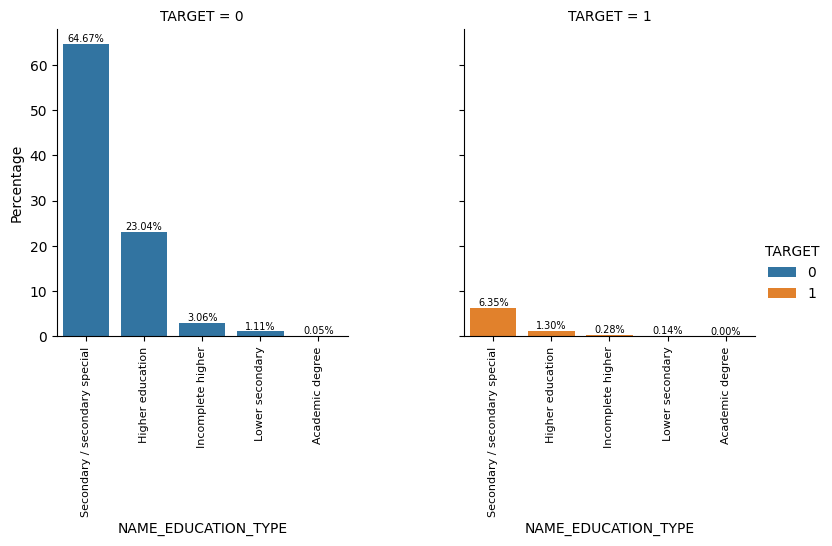

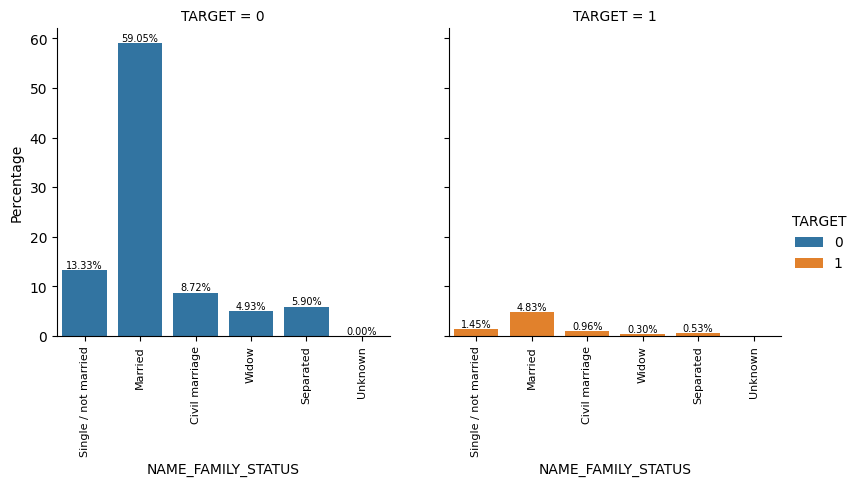

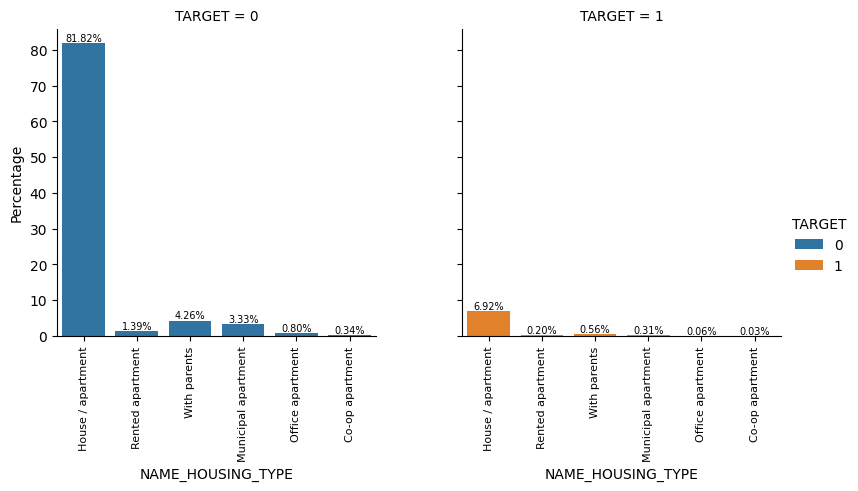

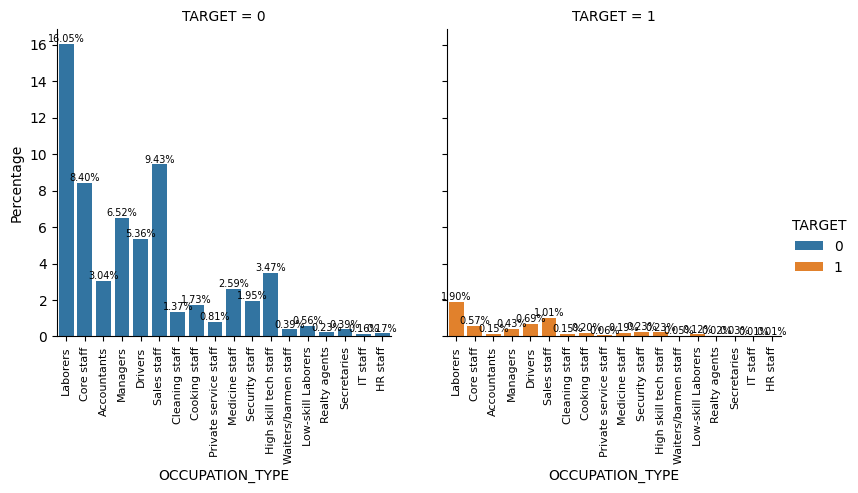

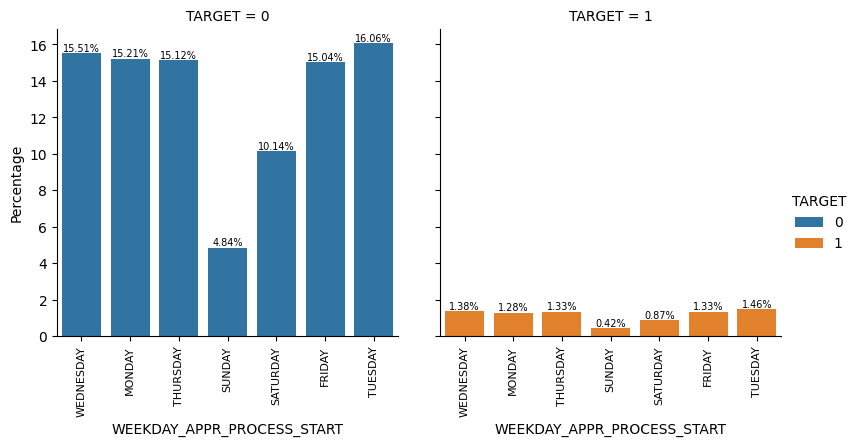

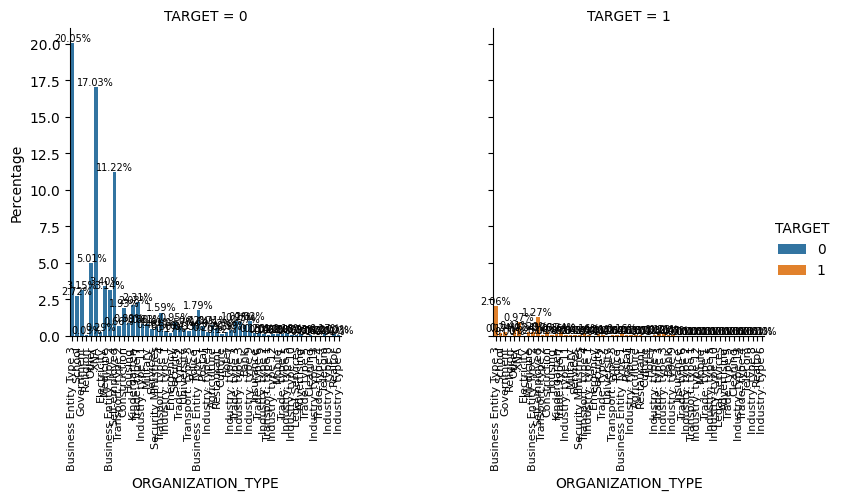

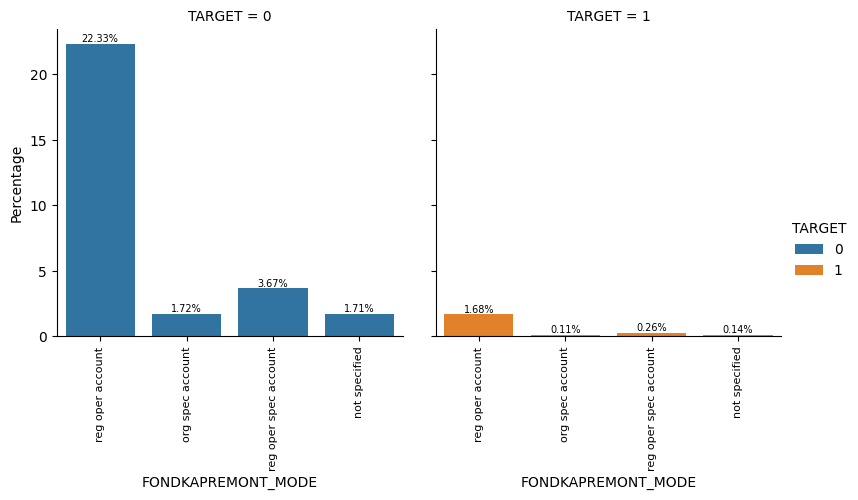

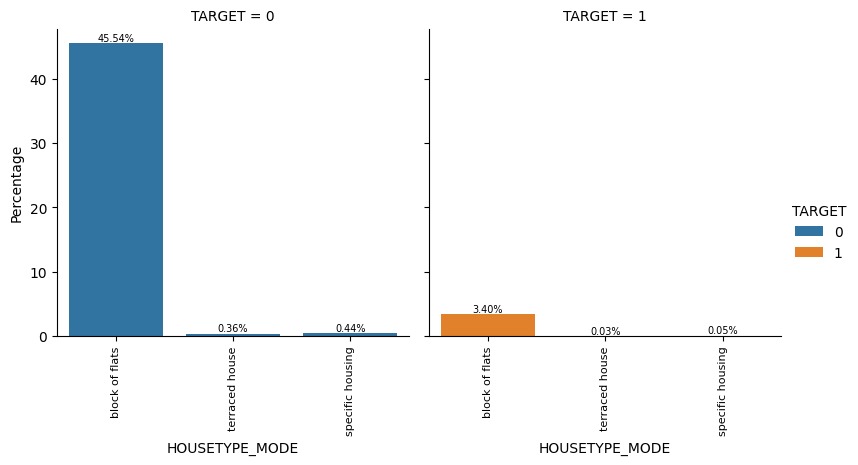

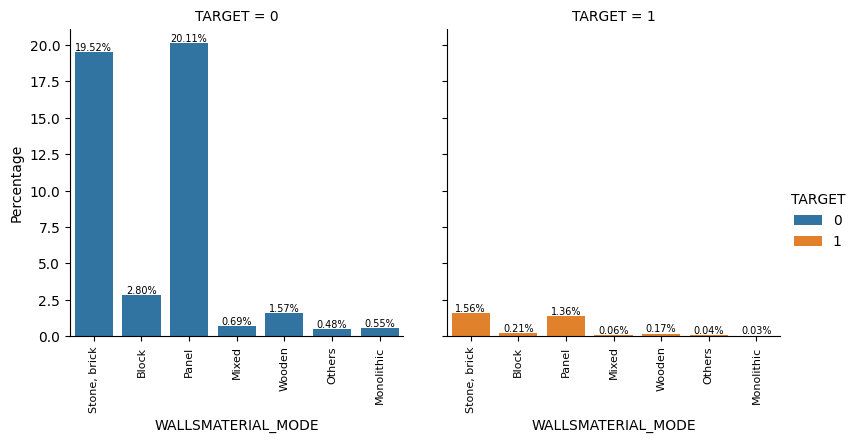

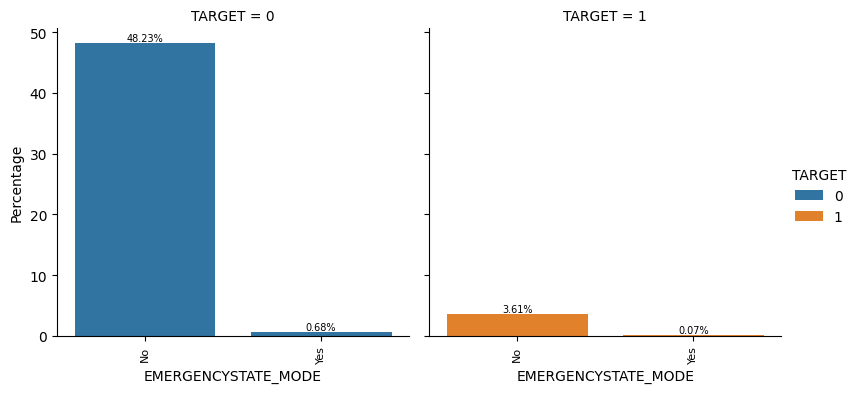

In [ ]:
for col in cat_cols:
    plot_cat(application_train, col)

After checking the values in categorical columns, I decided to

*   Drop CODE_GENDER = XNA since there are only 4 missing values in this column.
*   Drop SK_ID_CURR since it's unique values (we will use this index later in merging step).


In [ ]:
# Drop missing values in CODE_GENDER
rows_to_drop = application_train[application_train['CODE_GENDER'] == 'XNA'].index
application_train = application_train.drop(index=rows_to_drop)
application_train.reset_index(drop=True, inplace=True)

# Drop SK_ID_CURR
keep_SK_ID_CURR_train = application_train['SK_ID_CURR']
application_train = application_train.drop(columns=['SK_ID_CURR'])

print(application_train.shape)
application_train.head(3)

(307507, 121)


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Dealing with missing values for categorical features

In [ ]:
cat_cols = application_train.select_dtypes(include='object').columns.tolist()

# Missing values
(application_train[cat_cols].isnull().sum())/(application_train.shape[0])

NAME_CONTRACT_TYPE            0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
FLAG_OWN_REALTY               0.000000
NAME_TYPE_SUITE               0.004202
NAME_INCOME_TYPE              0.000000
NAME_EDUCATION_TYPE           0.000000
NAME_FAMILY_STATUS            0.000000
NAME_HOUSING_TYPE             0.000000
OCCUPATION_TYPE               0.313453
WEEKDAY_APPR_PROCESS_START    0.000000
ORGANIZATION_TYPE             0.000000
FONDKAPREMONT_MODE            0.683864
HOUSETYPE_MODE                0.501764
WALLSMATERIAL_MODE            0.508411
EMERGENCYSTATE_MODE           0.473986
dtype: float64

For missing values in categorical features:

*   Drop column which has more that 65% of missing values.
*   Fill in missing values with mode.




In [ ]:
application_train = application_train.drop(columns=['FONDKAPREMONT_MODE'])

col_fill_cat = ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

for col in col_fill_cat:
    mode_col = mode(application_train[col].dropna())
    application_train[col] = application_train[col].fillna(mode_col)

cat_cols.remove('FONDKAPREMONT_MODE')
application_train[cat_cols].isnull().sum()

NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
NAME_TYPE_SUITE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
OCCUPATION_TYPE               0
WEEKDAY_APPR_PROCESS_START    0
ORGANIZATION_TYPE             0
HOUSETYPE_MODE                0
WALLSMATERIAL_MODE            0
EMERGENCYSTATE_MODE           0
dtype: int64

## EDA for numerical features

### Since there are many numerical columns, I will drop the columns with missing value ratio > 65% before EDA.

In [ ]:
num_cols = application_train.select_dtypes(include='number').columns.tolist()
missing_ratios = (application_train[num_cols].isnull().sum() / application_train.shape[0])

missing_ratios_index = missing_ratios.index
missing_ratios_value = missing_ratios.values

drop_num_cols = missing_ratios_index[missing_ratios_value > 0.65]
drop_num_cols

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI'],
      dtype='object')

In [ ]:
application_train = application_train.drop(columns=drop_num_cols)
application_train.shape

(307507, 104)

### Categorical in term of numerical

In [ ]:
# Check numerical columns
num_cols = application_train.select_dtypes(include='number').columns.tolist()
num_cols.remove('TARGET')

# Group the categorical columns in term of numerical
cols_flag = [col for col in num_cols if 'FLAG' in col]
cols_cat_num = [col for col in application_train.columns if col.endswith(('_RATING_CLIENT', '_CITY', '_REGION'))]
cols_cat_num.extend(cols_flag)

cols_cat_num

['REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

**Chi-square test of independence**

In [ ]:
chi2_ls_numcat = []
pval_ls_numcat = []
for col in cols_cat_num:
    tab = pd.crosstab(application_train[col], application_train['TARGET'])
    chi2, p_val, _, _ = chi2_contingency(tab)
    chi2_ls_numcat.append(chi2)
    pval_ls_numcat.append(p_val)

pd_cats_chi2_numcat = pd.DataFrame({'Column name': cols_cat_num, 'Chi-square': chi2_ls_numcat, 'P-value': pval_ls_numcat})
pd_cats_chi2_numcat['Reject H0'] = pd_cats_chi2_numcat['P-value'] < 0.05
pd_cats_chi2_numcat

,Column name,Chi-square,P-value,Reject H0
0,REGION_RATING_CLIENT,1067.246464,1.779815e-232,True
1,REGION_RATING_CLIENT_W_CITY,1143.510115,4.897040e-249,True
2,REG_REGION_NOT_LIVE_REGION,9.392273,2.179018e-03,True
3,REG_REGION_NOT_WORK_REGION,14.699172,1.261018e-04,True
4,LIVE_REGION_NOT_WORK_REGION,2.391035,1.220328e-01,False
5,REG_CITY_NOT_LIVE_CITY,605.444509,1.095428e-133,True
6,REG_CITY_NOT_WORK_CITY,799.145537,8.276313e-176,True
7,LIVE_CITY_NOT_WORK_CITY,324.825295,1.287869e-72,True
8,FLAG_MOBIL,0.000000,1.000000e+00,False
9,FLAG_EMP_PHONE,649.796405,2.473940e-143,True



*   The categorical columns which have no significant different in target ($\alpha = 0.05$)  will be dropped.




In [ ]:
# Reject H0 --> there is a significant difference in feature and target
related_numcat_cols = pd_cats_chi2_numcat[pd_cats_chi2_numcat['Reject H0'] == True]['Column name'].values

print(len(related_numcat_cols))
related_numcat_cols

21


array(['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_18'],
      dtype=object)

In [ ]:
related_numcat_cols_plot = [col for col in related_numcat_cols if 'FLAG' not in col]
related_numcat_cols_plot

['REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

From the below plots, there are some interesting findings when comparing the proportion of defaults in TARGET=0 and TARGET=1 for each group

Column name | Note
--- | ---
REGION_RATING_CLIENT | Group 1 seems to have less risk while group 3 has more risk.
REGION_RATING_CLIENT_W_CITY | Group 1 seems to have less risk while group 3 has more risk.
REG_REGION_NOT_LIVE_REGION | Group 0 seems to have less risk
REG_REGION_NOT_WORK_REGION | Group 0 seems to have less risk
REG_CITY_NOT_LIVE_CITY | Group 0 seems to have less risk
REG_CITY_NOT_WORK_CITY | Group 0 seems to have less risk
LIVE_CITY_NOT_WORK_CITY | Group 0 seems to have less risk

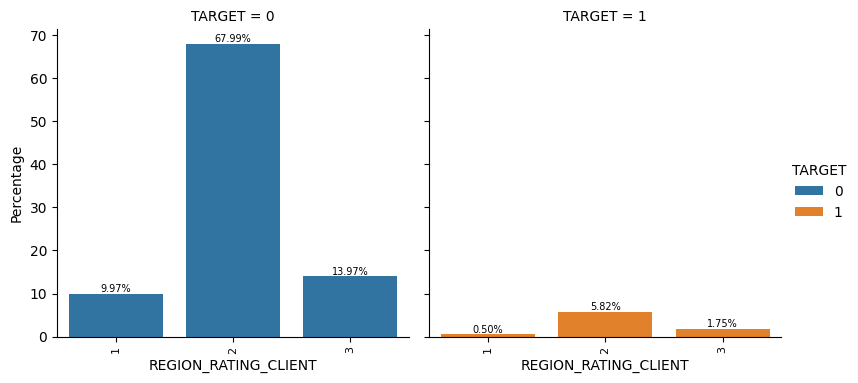

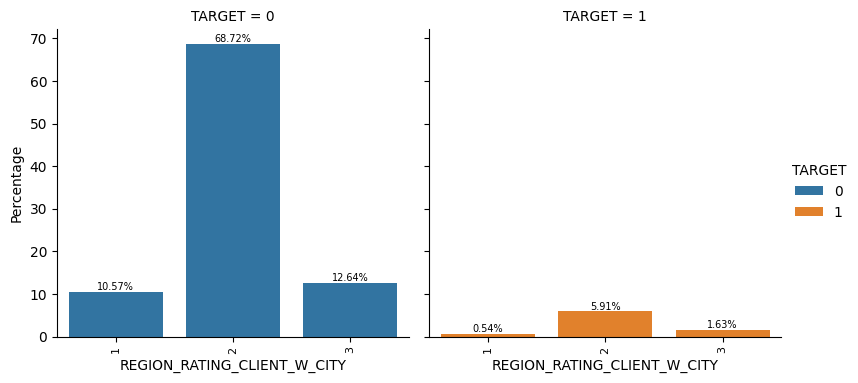

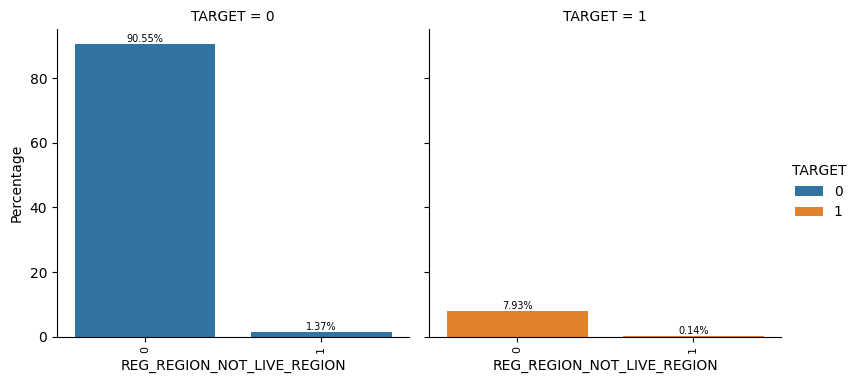

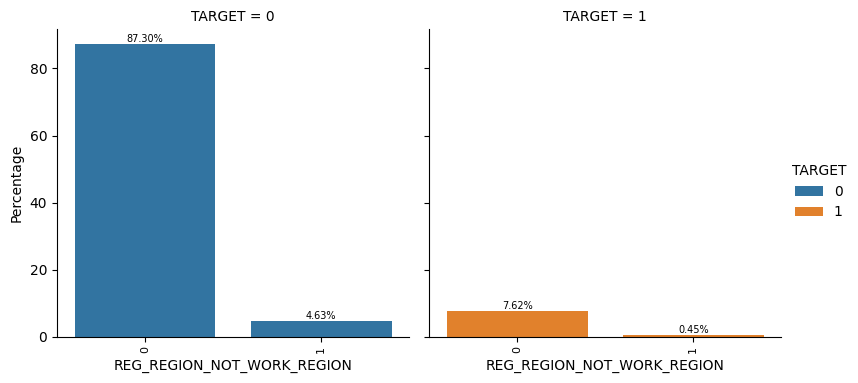

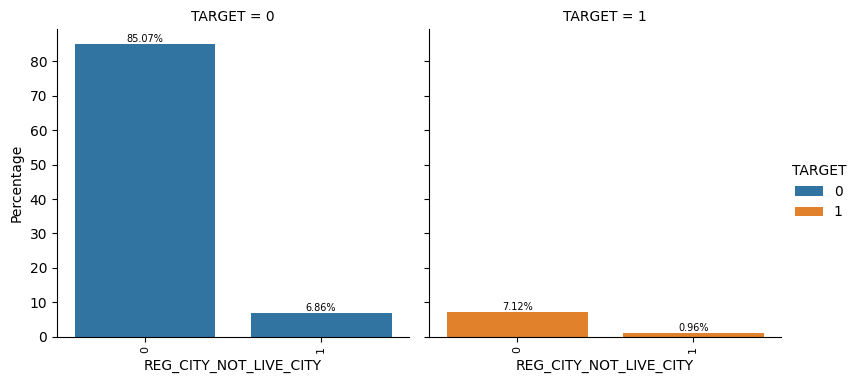

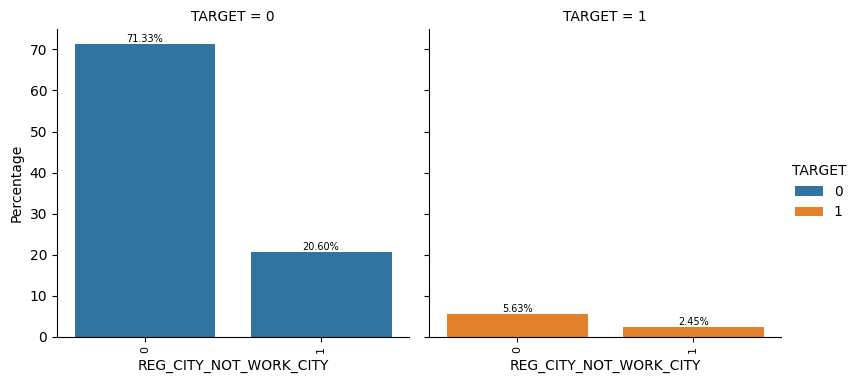

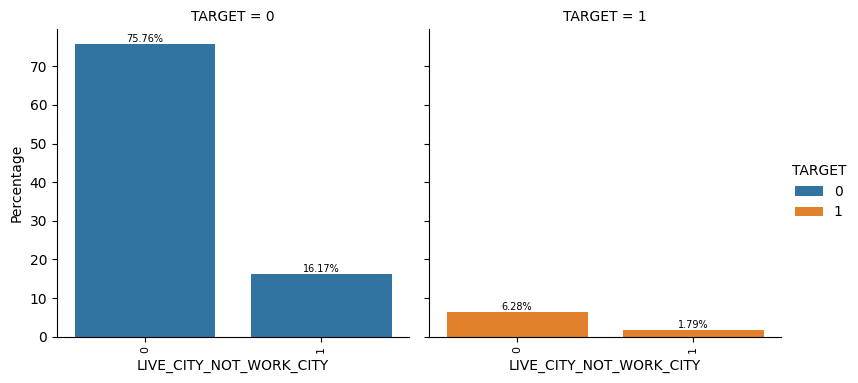

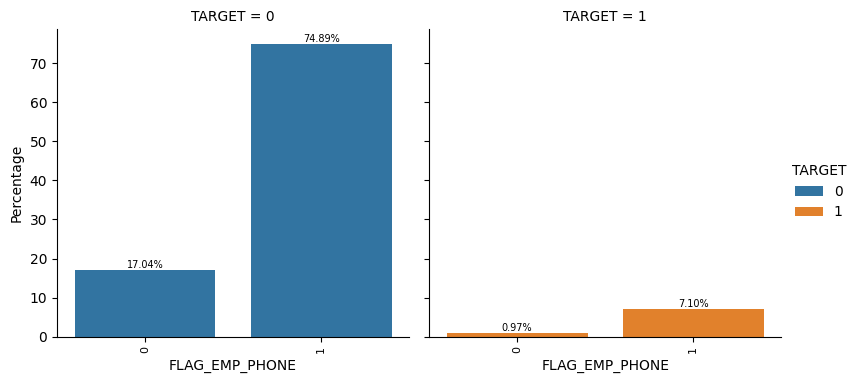

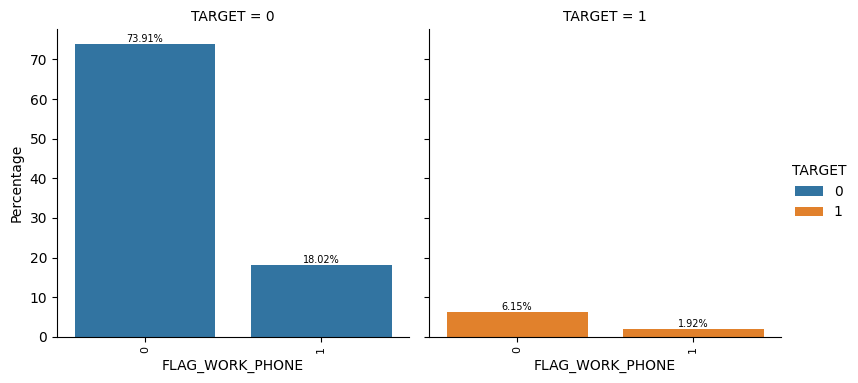

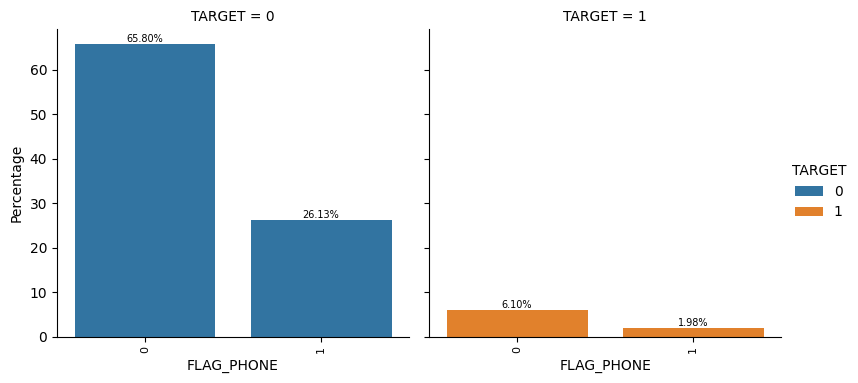

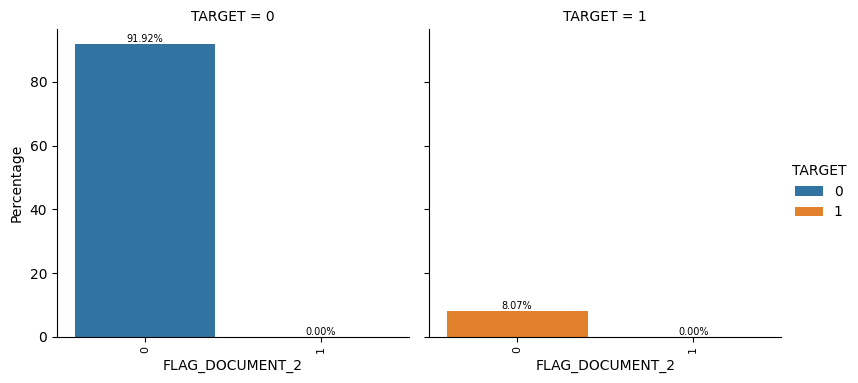

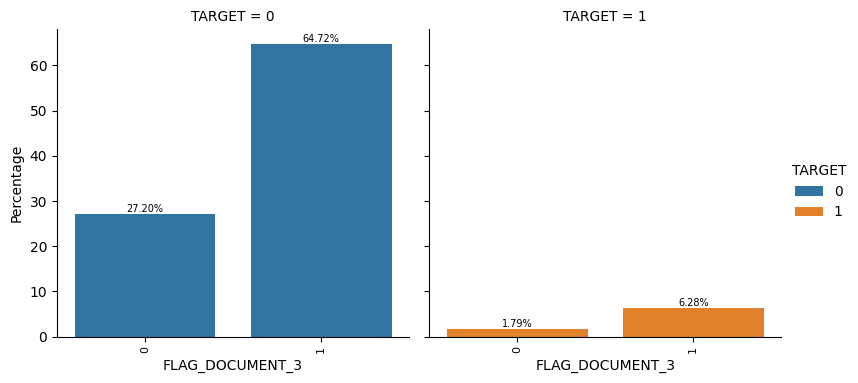

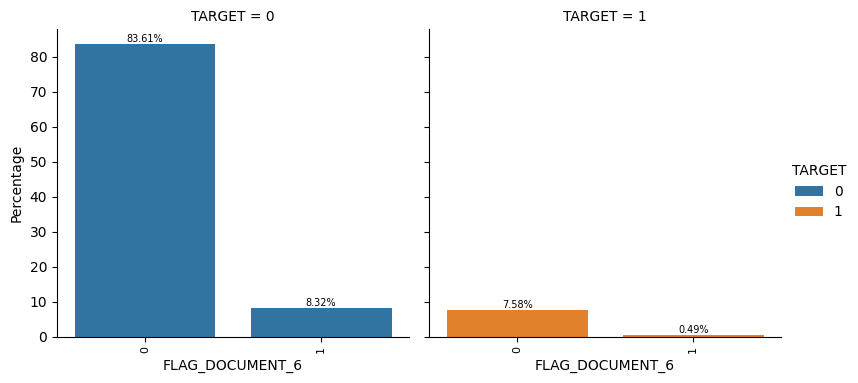

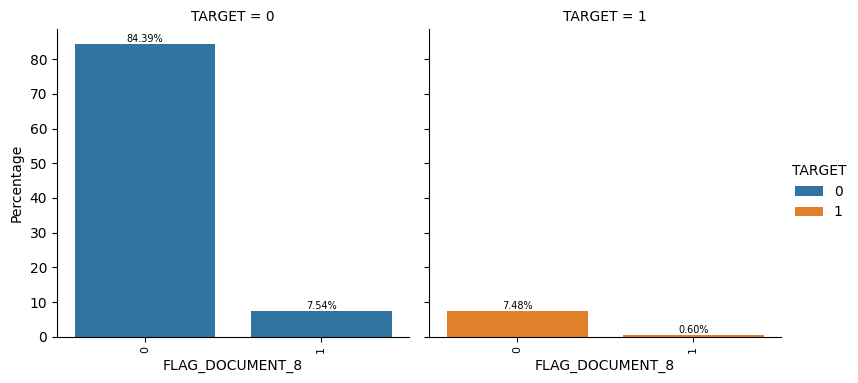

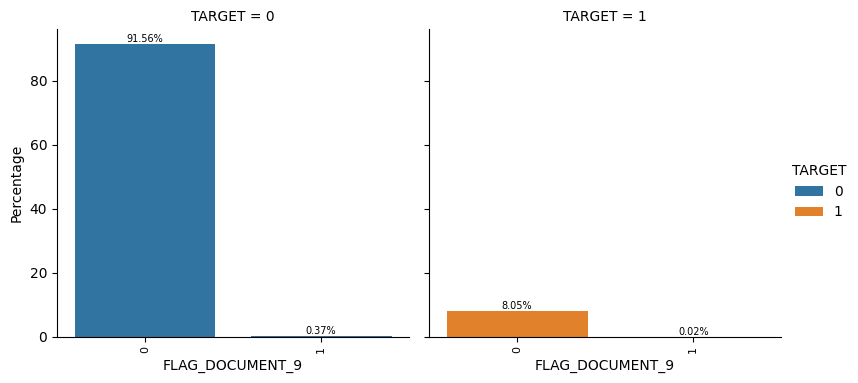

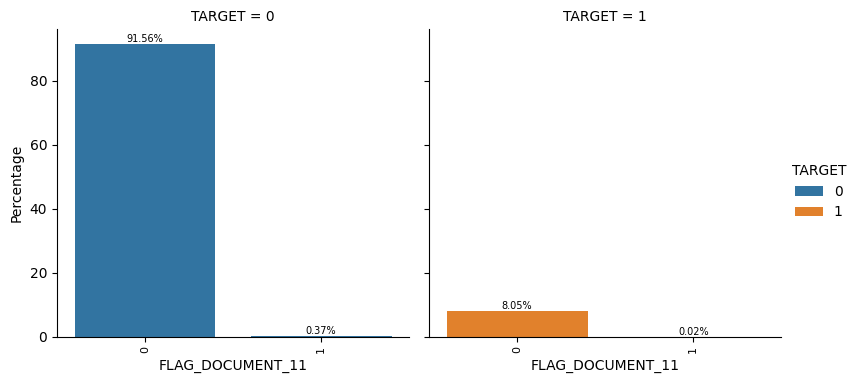

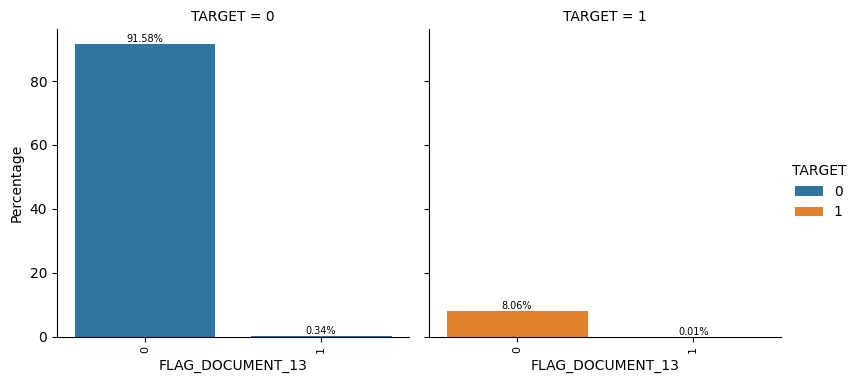

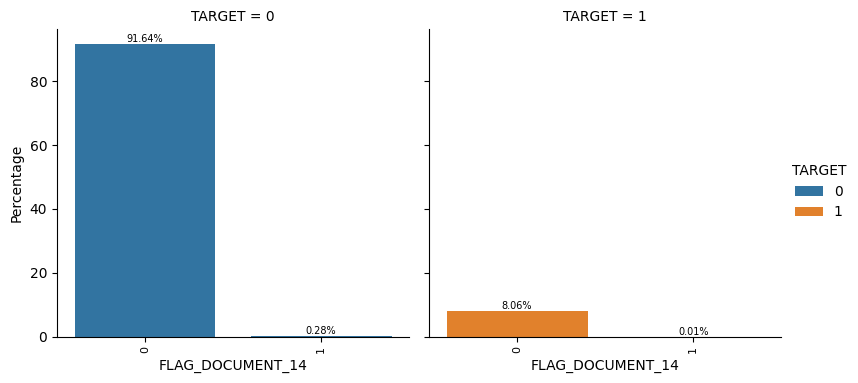

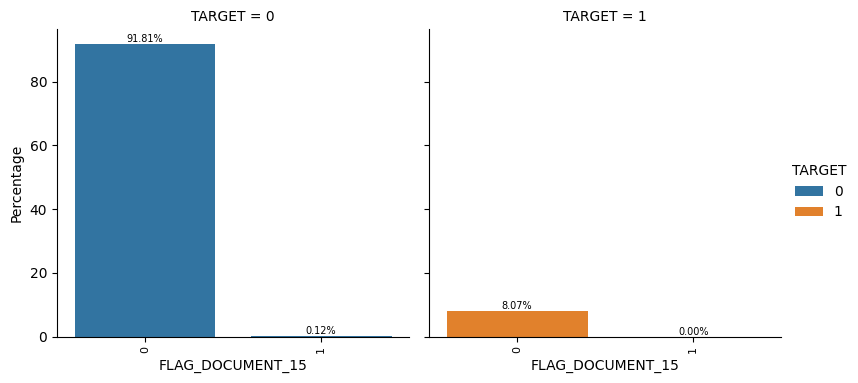

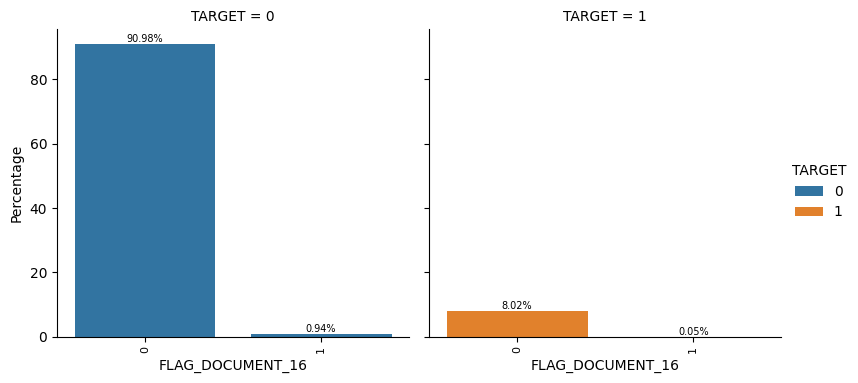

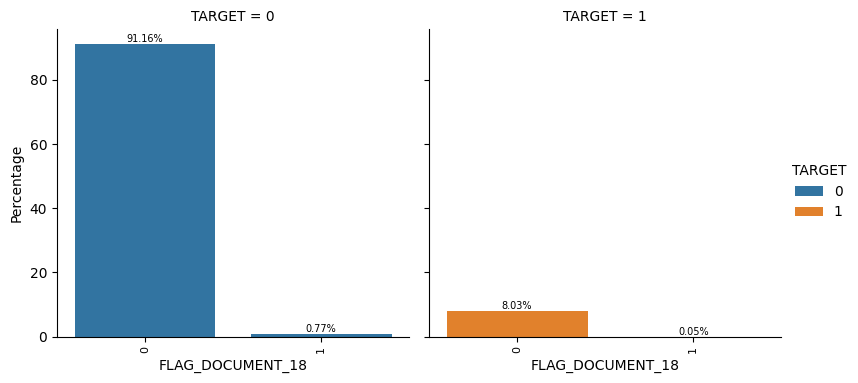

In [ ]:
for col in related_numcat_cols:
    plot_cat(application_train, col)

In [ ]:
# Fail to reject H0: There is no significant difference in means between two groups (0/1)
not_related_numcat_cols = pd_cats_chi2_numcat[pd_cats_chi2_numcat['Reject H0'] == False]['Column name'].values
not_related_numcat_cols

array(['LIVE_REGION_NOT_WORK_REGION', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE',
       'FLAG_EMAIL', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21'], dtype=object)

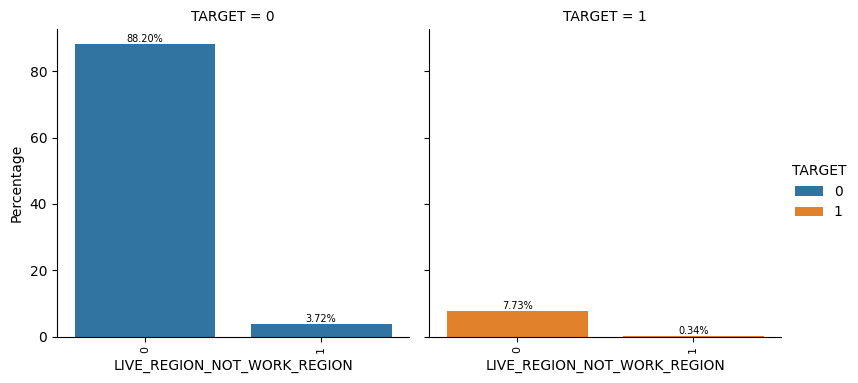

In [ ]:
# Example plot
plot_cat(application_train, 'LIVE_REGION_NOT_WORK_REGION')

In [ ]:
application_train = application_train.drop(columns=not_related_numcat_cols)
application_train.shape

(307507, 91)

In [ ]:
application_train[related_numcat_cols].isnull().sum()

REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_PHONE                     0
FLAG_DOCUMENT_2                0
FLAG_DOCUMENT_3                0
FLAG_DOCUMENT_6                0
FLAG_DOCUMENT_8                0
FLAG_DOCUMENT_9                0
FLAG_DOCUMENT_11               0
FLAG_DOCUMENT_13               0
FLAG_DOCUMENT_14               0
FLAG_DOCUMENT_15               0
FLAG_DOCUMENT_16               0
FLAG_DOCUMENT_18               0
dtype: int64

### Numerical features

In [ ]:
num_cols = application_train.select_dtypes(include='number').columns.tolist()

cols_num_others = [col for col in num_cols if col not in related_numcat_cols]
cols_num_others.remove('TARGET')
print(len(cols_num_others))
cols_num_others

54


['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'CNT_FAM_MEMBERS',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LANDAREA_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LANDAREA_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 

In [ ]:
application_train[cols_num_others].describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307505.000000,307507.000000,134131.000000,3.068470e+05,246542.000000,151447.000000,127565.000000,157501.000000,143617.000000,152680.000000,154488.000000,124919.000000,153158.000000,137827.000000,151447.000000,127565.000000,157501.000000,143617.000000,152680.000000,154488.000000,124919.000000,153158.000000,137827.000000,151447.000000,127565.000000,157501.000000,143617.000000,152680.000000,154488.000000,124919.000000,153158.000000,137827.000000,159077.000000,306486.000000,306486.000000,306486.000000,306486.000000,307506.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000
mean,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,0.020868,-16037.027271,63815.929208,-4986.131376,-2994.201670,2.152658,12.063394,0.502129,5.143918e-01,0.510856,0.117442,0.088443,0.977735,0.078943,0.149726,0.226284,0.066334,0.107400,0.028358,0.114232,0.087543,0.977065,0.074491,0.145194,0.222317,0.064958,0.105976,0.027023,0.117851,0.087955,0.977752,0.078079,0.149214,0.225899,0.067169,0.108608,0.028236,0.102548,1.422209,0.143406,1.405255,0.100034,-962.860546,0.006403,0.007000,0.034362,0.267388,0.265474,1.899950
std,0.722119,2.371246e+05,4.024926e+05,14493.798379,3.694472e+05,0.013831,4363.982424,141276.472519,3522.883030,1509.454566,0.910680,3.265835,0.211063,1.910603e-01,0.194843,0.108241,0.082439,0.059224,0.134577,0.100050,0.144641,0.081184,0.110565,0.069524,0.107937,0.084308,0.064576,0.132257,0.100978,0.143710,0.081751,0.111846,0.070254,0.109076,0.082179,0.059898,0.134468,0.100369,0.145067,0.082167,0.112261,0.070167,0.107463,2.400931,0.446644,2.379744,0.362221,826.811491,0.083850,0.110758,0.204686,0.915994,0.794060,1.869286
min,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,1.000000,0.000000,0.014568,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,2.000000,10.000000,0.334007,3.924574e-01,0.370650,0.057700,0.044200,0.976700,0.000000,0.069000,0.166700,0.018700,0.045300,0.000000,0.052500,0.040700,0.976700,0.000000,0.069000,0.166700,0.016600,0.042700,0.000000,0.058300,0.043700,0.976700,0.000000,0.069000,0.166700,0.018700,0.045700,0.000000,0.041200,0.000000,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,-3254.000000

In [ ]:
t_stat = []
p_value = []
for col in cols_num_others:
    group_0 = application_train[application_train['TARGET'] == 0][col].dropna()
    group_1 = application_train[application_train['TARGET'] == 1][col].dropna()

    t_statistic, p_val = ttest_ind(group_0, group_1)
    t_stat.append(t_statistic)
    p_value.append(p_val)

df_num_t_test = pd.DataFrame({'Column name': cols_num_others, 'T-statistic': t_stat, 'P-value': p_value})
df_num_t_test['Reject H0'] = df_num_t_test['P-value'] < 0.05
df_num_t_test

,Column name,T-statistic,P-value,Reject H0
0,CNT_CHILDREN,-10.642924,1.901380e-26,True
1,AMT_INCOME_TOTAL,2.207927,2.725012e-02,True
2,AMT_CREDIT,16.849597,1.128335e-63,True
3,AMT_ANNUITY,7.108704,1.173909e-12,True
4,AMT_GOODS_PRICE,21.992686,4.095498e-107,True
5,REGION_POPULATION_RELATIVE,20.656672,9.864650e-95,True
6,DAYS_BIRTH,-43.521149,0.000000e+00,True
7,DAYS_EMPLOYED,24.942286,3.548823e-137,True
8,DAYS_REGISTRATION,-23.297613,5.959413e-120,True
9,DAYS_ID_PUBLISH,-28.572514,2.537564e-179,True


Reject H0 --> there is a significant difference in means between two groups (0/1) at $\alpha = 0.5$.

In [ ]:
related_num_cols = df_num_t_test[df_num_t_test['Reject H0'] == True]['Column name'].values

print(len(related_num_cols))
related_num_cols

50


array(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_AVG',
       'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LANDAREA_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
       'FLOORSMAX_MODE', 'LANDAREA_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
       'FLOORSMAX_MEDI', 'LANDAREA_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE',

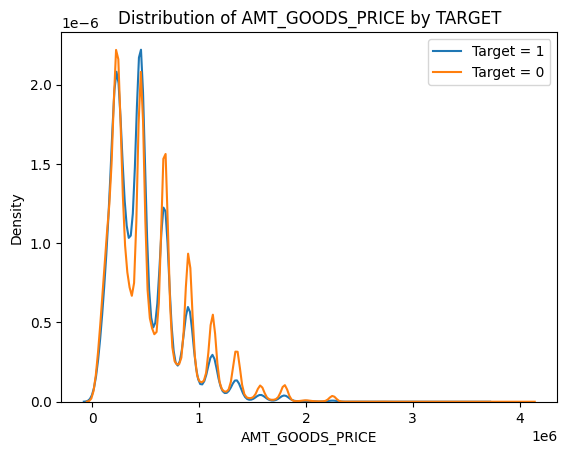

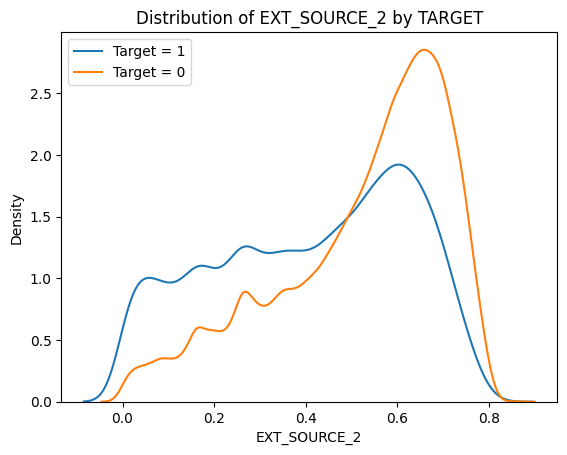

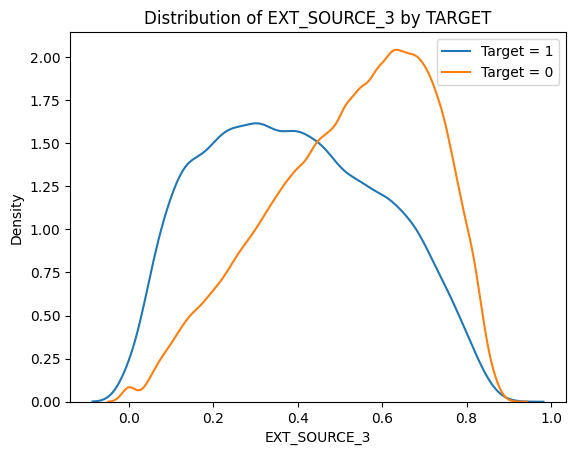

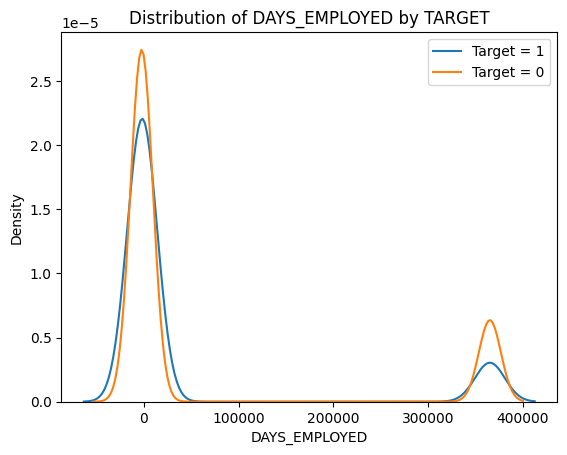

In [ ]:
# Example distribution plot

for col in ['AMT_GOODS_PRICE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED']:
    for target_value in application_train['TARGET'].unique():
        sns.distplot(application_train[application_train['TARGET'] == target_value][col], label=f'Target = {target_value}', hist=False)

    plt.title(f'Distribution of {col} by TARGET')
    plt.legend()
    plt.show()

Fail to reject H0: There is no significant difference in means between two groups (0/1) at $\alpha = 0.5$.

In [ ]:
not_related_num_cols = df_num_t_test[df_num_t_test['Reject H0'] == False]['Column name'].values
not_related_num_cols

array(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_QRT'],
      dtype=object)

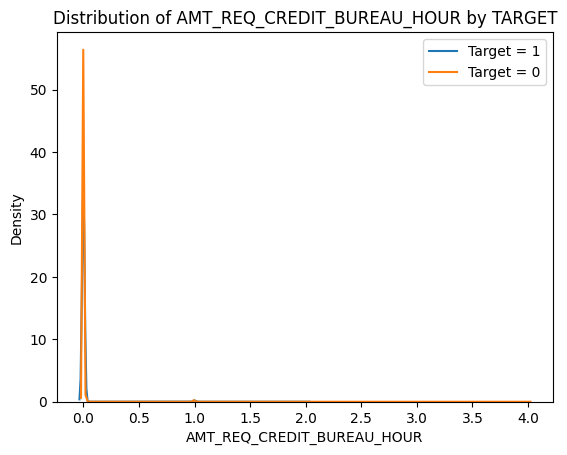

In [ ]:
# Example distribution plot
for target_value in application_train['TARGET'].unique():
    sns.distplot(application_train[application_train['TARGET'] == target_value]['AMT_REQ_CREDIT_BUREAU_HOUR'], label=f'Target = {target_value}', hist=False)

plt.title('Distribution of AMT_REQ_CREDIT_BUREAU_HOUR by TARGET')
plt.legend()
plt.show()

In [ ]:
application_train = application_train.drop(columns=not_related_num_cols)
application_train.shape

(307507, 87)

In [ ]:
application_train[related_num_cols].isnull().sum()

CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
CNT_FAM_MEMBERS                      2
HOUR_APPR_PROCESS_START              0
EXT_SOURCE_1                    173376
EXT_SOURCE_2                       660
EXT_SOURCE_3                     60965
APARTMENTS_AVG                  156060
BASEMENTAREA_AVG                179942
YEARS_BEGINEXPLUATATION_AVG     150006
ELEVATORS_AVG                   163890
ENTRANCES_AVG                   154827
FLOORSMAX_AVG                   153019
LANDAREA_AVG                    182588
LIVINGAREA_AVG                  154349
NONLIVINGAREA_AVG               169680
APARTMENTS_MODE                 156060
BASEMENTAREA_MODE        

## Dealing with missing values for numerical features

In [ ]:
application_train[related_num_cols].describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR
count,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307505.000000,307507.000000,134131.000000,3.068470e+05,246542.000000,151447.000000,127565.000000,157501.000000,143617.000000,152680.000000,154488.000000,124919.000000,153158.000000,137827.000000,151447.000000,127565.000000,157501.000000,143617.000000,152680.000000,154488.000000,124919.000000,153158.000000,137827.000000,151447.000000,127565.000000,157501.000000,143617.000000,152680.000000,154488.000000,124919.000000,153158.000000,137827.000000,159077.000000,306486.000000,306486.000000,306486.000000,306486.000000,307506.000000,265988.000000,265988.000000
mean,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,0.020868,-16037.027271,63815.929208,-4986.131376,-2994.201670,2.152658,12.063394,0.502129,5.143918e-01,0.510856,0.117442,0.088443,0.977735,0.078943,0.149726,0.226284,0.066334,0.107400,0.028358,0.114232,0.087543,0.977065,0.074491,0.145194,0.222317,0.064958,0.105976,0.027023,0.117851,0.087955,0.977752,0.078079,0.149214,0.225899,0.067169,0.108608,0.028236,0.102548,1.422209,0.143406,1.405255,0.100034,-962.860546,0.267388,1.899950
std,0.722119,2.371246e+05,4.024926e+05,14493.798379,3.694472e+05,0.013831,4363.982424,141276.472519,3522.883030,1509.454566,0.910680,3.265835,0.211063,1.910603e-01,0.194843,0.108241,0.082439,0.059224,0.134577,0.100050,0.144641,0.081184,0.110565,0.069524,0.107937,0.084308,0.064576,0.132257,0.100978,0.143710,0.081751,0.111846,0.070254,0.109076,0.082179,0.059898,0.134468,0.100369,0.145067,0.082167,0.112261,0.070167,0.107463,2.400931,0.446644,2.379744,0.362221,826.811491,0.915994,1.869286
min,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,1.000000,0.000000,0.014568,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000
25%,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,2.000000,10.000000,0.334007,3.924574e-01,0.370650,0.057700,0.044200,0.976700,0.000000,0.069000,0.166700,0.018700,0.045300,0.000000,0.052500,0.040700,0.976700,0.000000,0.069000,0.166700,0.016600,0.042700,0.000000,0.058300,0.043700,0.976700,0.000000,0.069000,0.166700,0.018700,0.045700,0.000000,0.041200,0.000000,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000
50%,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,-3254.000000,2.000000,12.000000,0.505998,5.659614e-01,0.535276,0.087600,0.076300,0.981600,0.000000,0.137900,0.166700,0.048100,0.074500,0.003600,0.084000,0.074600,0.981600,0.000000,0.137900,0.166700,0.045800,0.073100,0.001100,0.086400,0.075800,0.981600,0.000000,0.137900,0.166700,0.048700,0.074900,0.003100,0.068800,0.0

In [ ]:
null_prop = application_train[related_num_cols].isnull().sum()/application_train.shape[0]

cols_notnull = null_prop[null_prop == 0].index
cols_check = null_prop[null_prop > 0].index

In [ ]:
for col in cols_check:
    col_mean = application_train[col].mean()
    application_train[col] = application_train[col].fillna(col_mean)

sum(application_train.isnull().sum())

0

## Consider some group of related features

*   Building details
*   AMT columns
*   External sources
*   Social surroundings

Check correlation in each group and drop the high correlated features (corr > 0.8) and keep the most relevant one.


In [ ]:
# Features related to building details
cols_building = [col for col in application_train.columns if col.endswith(('_AVG', '_MODE', '_MEDI'))]
cols_building.remove('EMERGENCYSTATE_MODE')

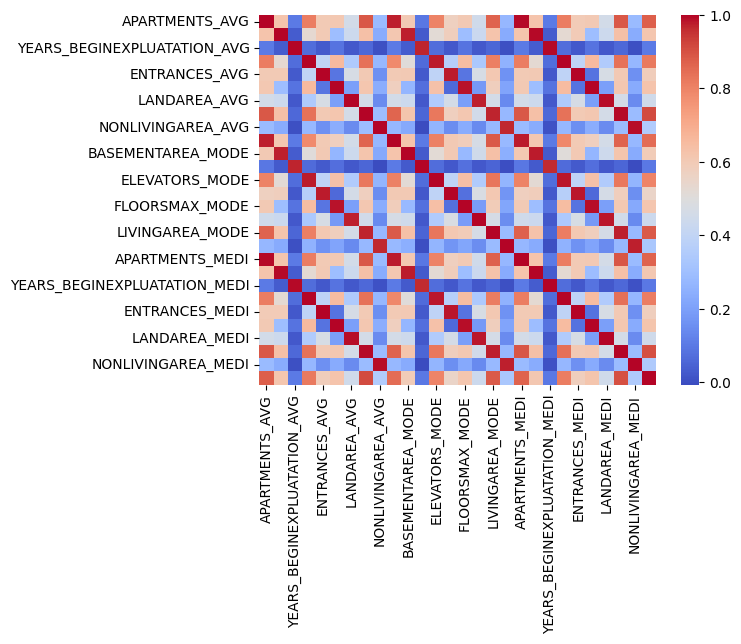

In [ ]:
sns.heatmap(application_train[cols_building].corr(), cmap='coolwarm');

Many features are correlated, so I decided to keep only the most relevant column.

In [ ]:
test_feat = cols_building.copy()
test_feat.append('TARGET')

In [ ]:
correlation_with_target = application_train[test_feat].corr()['TARGET'].abs().sort_values(ascending=False)
keep_building_col = correlation_with_target.index[1]
keep_building_col

'FLOORSMAX_AVG'

In [ ]:
cols_building.remove(keep_building_col)

In [ ]:
application_train = application_train.drop(columns=cols_building)
application_train.shape

(307507, 58)

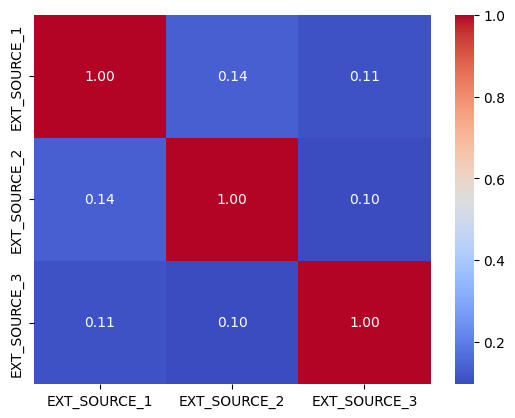

In [ ]:
# Features related to External Source data
sns.heatmap(application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].corr(), cmap='coolwarm', annot=True, fmt=".2f");

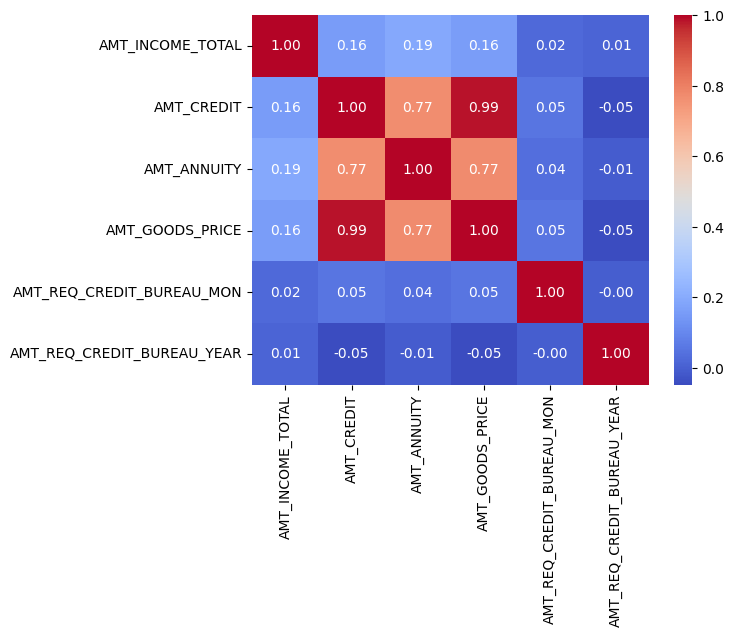

In [ ]:
# Features related to Amount
all_col_whole = application_train.columns
cols_amt = list(all_col_whole[all_col_whole.str.contains('AMT')])
sns.heatmap(application_train[cols_amt].corr(), cmap='coolwarm', annot=True, fmt=".2f");

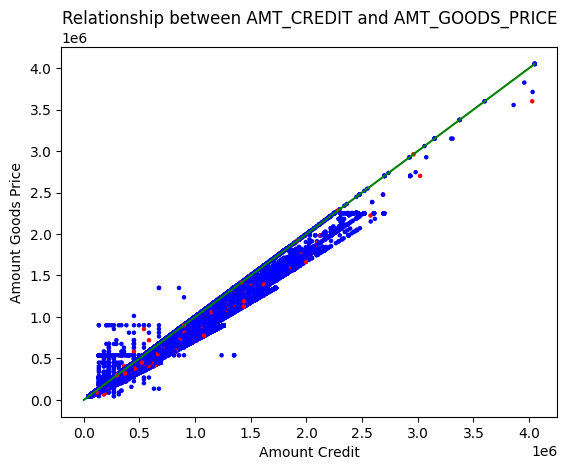

In [ ]:
colors = ['blue' if val == 0 else 'red' for val in application_train['TARGET']]
plt.scatter(application_train['AMT_CREDIT'], application_train['AMT_GOODS_PRICE'], s=5, c=colors)
x = range(0, int(max(application_train['AMT_CREDIT'])))
plt.plot(x, x, color='g', label='AMT_CREDIT=AMT_GOODS_PRICE')
plt.title('Relationship between AMT_CREDIT and AMT_GOODS_PRICE')
plt.xlabel('Amount Credit')
plt.ylabel('Amount Goods Price')
plt.show()

In [ ]:
test_feat = ['AMT_CREDIT', 'AMT_GOODS_PRICE', 'TARGET']
correlation_with_target = application_train[test_feat].corr()['TARGET'].abs().sort_values(ascending=False)
keep_building_col = correlation_with_target.index[1]
keep_building_col

'AMT_GOODS_PRICE'

In [ ]:
application_train = application_train.drop(columns=['AMT_CREDIT'])
application_train.shape

(307507, 57)

In [ ]:
# Features related to Social Circle
all_col_whole = application_train.columns
col_circle = all_col_whole[all_col_whole.str.contains('CIRCLE')]
col_circle

Index(['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'],
      dtype='object')

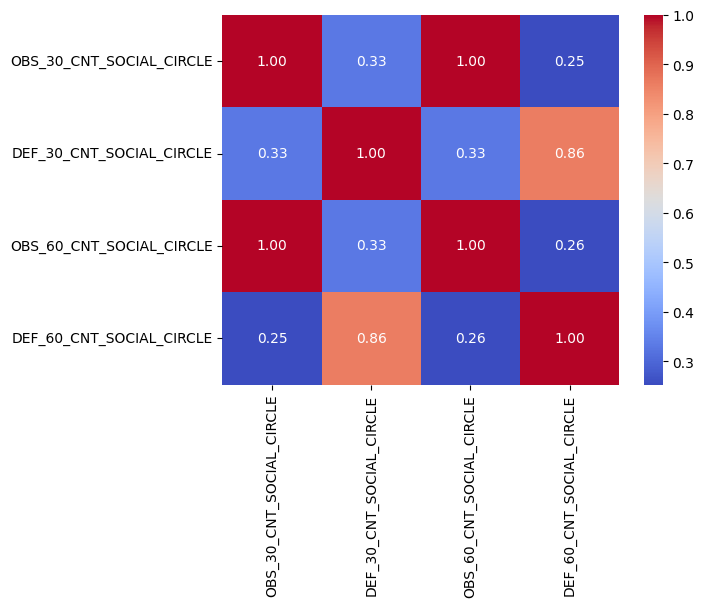

In [ ]:
sns.heatmap(application_train[col_circle].corr(), cmap='coolwarm', annot=True, fmt=".2f");

In [ ]:
col_circle = list(col_circle)
col_circle.append('TARGET')
application_train[col_circle].corr()['TARGET'].abs().sort_values(ascending=False)

TARGET                      1.000000
DEF_30_CNT_SOCIAL_CIRCLE    0.032235
DEF_60_CNT_SOCIAL_CIRCLE    0.031270
OBS_30_CNT_SOCIAL_CIRCLE    0.009128
OBS_60_CNT_SOCIAL_CIRCLE    0.009020
Name: TARGET, dtype: float64

In [ ]:
application_train = application_train.drop(columns=['DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE'])
application_train.shape

(307507, 55)

In [ ]:
# Features related to Days
all_col_whole = application_train.columns
cols_days = list(all_col_whole[all_col_whole.str.contains('DAYS_')])
cols_days

['DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE']

There are some incorrect in DAYS. I will fix this later with fitting outliers.

In [ ]:
(sum(application_train['DAYS_BIRTH'] < application_train['DAYS_EMPLOYED'])/application_train.shape[0],
sum(application_train['DAYS_BIRTH'] < application_train['DAYS_REGISTRATION'])/application_train.shape[0],
sum(application_train['DAYS_BIRTH'] < application_train['DAYS_ID_PUBLISH'])/application_train.shape[0],
sum(application_train['DAYS_BIRTH'] < application_train['DAYS_LAST_PHONE_CHANGE'])/application_train.shape[0])

(1.0, 0.9970537256062464, 1.0, 1.0)

In [ ]:
# Create column: AGE
application_train['AGE'] = abs(application_train['DAYS_BIRTH']/365)
application_train = application_train.drop(columns=['DAYS_BIRTH'])

tab = pd.crosstab(application_train['AGE'], application_train['TARGET'])
chi2, p_val, _, _ = chi2_contingency(tab)
chi2, p_val

(19140.166979623384, 1.3106388772283307e-18)

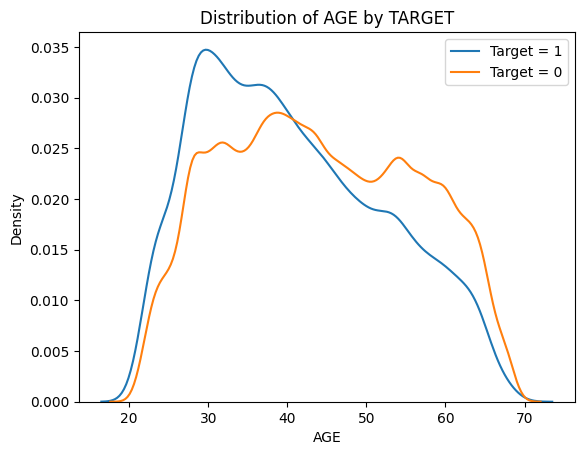

In [ ]:
for target_value in application_train['TARGET'].unique():
    sns.distplot(application_train[application_train['TARGET'] == target_value]['AGE'], label=f'Target = {target_value}', hist=False)

plt.title(f'Distribution of AGE by TARGET')
plt.legend()
plt.show()

# Data Preparation

In this step, we need to check if any data is missing after merging tables. If there are any missing values, we will fill them in with the mean (for numerical columns) and mode (for categorical columns). It is important to make sure that the outliers of the numerical columns are fixed, as we have found during the EDA step. Additionally, the numerical data will be normalized with MinMaxScaler. On the other hand, for categorical data, we will apply OneHotEncoder.

## Useful function

In [ ]:
def fix_outliers(table, cols):
    table_cleaned = table.copy()

    for col in cols:
        q25 = table[col].quantile(0.25)
        q75 = table[col].quantile(0.75)
        iqr = q75 - q25

        LB = q25 - 1.5 * iqr
        UB = q75 + 1.5 * iqr

        table_cleaned[col] = table_cleaned[col].apply(lambda x: LB if x < LB else UB if x > UB else x)

    return table_cleaned

## Main files

In [ ]:
# keep SK_ID_CURR from train
application_train_ori = pd.read_csv('/content/kaggle/dataset/application_train.csv')
rows_to_drop = application_train_ori[application_train_ori['CODE_GENDER'] == 'XNA'].index
application_train_ori = application_train_ori.drop(index=rows_to_drop)
application_train_ori.reset_index(drop=True, inplace=True)
keep_SK_ID_CURR_train = application_train_ori['SK_ID_CURR']

# application_test
application_test = pd.read_csv('/content/kaggle/dataset/application_test.csv')
application_test['AGE'] = abs(application_test['DAYS_BIRTH']/365)

# keep SK_ID_CURR from test
SK_ID_CURR_test = application_test['SK_ID_CURR']

# Choose columns
col_train = application_train.columns.tolist()
col_train.remove('TARGET')
application_test = application_test[col_train]

## fill in missing values in test set
col_test_fill_num = ['AMT_ANNUITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLOORSMAX_AVG',
                     'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
                     'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR']
col_test_fill_cat = ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'EMERGENCYSTATE_MODE']

for col in col_test_fill_num:
    col_mean = application_train[col].mean()
    application_test[col] = application_test[col].fillna(col_mean)

for col in col_test_fill_cat:
    mode_col = mode(application_train[col].dropna())
    application_test[col] = application_test[col].fillna(mode_col)

# Separate columns in train and group columns (numerical/categorical)
y = application_train['TARGET']
X = application_train.drop(columns=['TARGET'])

cols_cat = X.select_dtypes(include='object').columns.tolist()
cols_num = X.select_dtypes(include='number').columns.tolist()
cols_num_final = [col for col in cols_num if X[col].nunique() > 5]

# Categorical features
X_cat = X[cols_cat]
X_test_cat = application_test[cols_cat]

encoder = OneHotEncoder()
X_cat_encoded = encoder.fit_transform(X_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

X_train_cat_encoded_pd = pd.DataFrame(X_cat_encoded.toarray(), columns=encoder.get_feature_names_out(X_cat.columns))
X_test_cat_encoded_pd = pd.DataFrame(X_test_cat_encoded.toarray(), columns=encoder.get_feature_names_out(X_test_cat.columns))

# Numerical features
X_num_pd = X[cols_num_final]
X_test_num_pd = application_test[cols_num_final]

X_num_pd = fix_outliers(X_num_pd, X_num_pd.columns)
X_test_num_pd = fix_outliers(X_test_num_pd, X_test_num_pd.columns)

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X_num_pd)
X_test_scaled = scaler.transform(X_test_num_pd)

X_scaled_pd = pd.DataFrame(X_scaled, columns=cols_num_final)
X_test_scaled_pd = pd.DataFrame(X_test_scaled, columns=cols_num_final)

# Concatenate tables
X_pd = pd.concat([X_scaled_pd, X_train_cat_encoded_pd], axis=1)
X_test_pd = pd.concat([X_test_scaled_pd, X_test_cat_encoded_pd], axis=1)

# Prepare for merging

application_train_for_merge = X_pd.copy()
application_train_for_merge['SK_ID_CURR'] = keep_SK_ID_CURR_train

application_test_for_merge = X_test_pd.copy()
application_test_for_merge['SK_ID_CURR'] = SK_ID_CURR_test

In [ ]:
application_test_for_merge.shape, application_train_for_merge.shape

((48744, 146), (307507, 146))

## Additional data

### previous_application

In [ ]:
prev = pd.read_csv('/content/kaggle/dataset/previous_application.csv')

# Important info: approval of last contract, group of interest rate and the date termination >> provide some interesting about risk
col_selected = ['SK_ID_CURR', 'NAME_CONTRACT_STATUS', 'NAME_YIELD_GROUP', 'DAYS_TERMINATION']
imp_risk = prev[col_selected]

# delete outlier in max date
max_date_is_outlier = max(imp_risk['DAYS_TERMINATION'])
idx = imp_risk[imp_risk['DAYS_TERMINATION'] == max_date_is_outlier].index
imp_risk.loc[idx, 'DAYS_TERMINATION'] = np.nan

imp_risk_cat = imp_risk[['NAME_CONTRACT_STATUS', 'NAME_YIELD_GROUP']]
imp_risk_num = imp_risk[['SK_ID_CURR', 'DAYS_TERMINATION']]

encoder = OneHotEncoder()
imp_risk_cat_encoded = encoder.fit_transform(imp_risk_cat)
imp_risk_cat_encoded_pd = pd.DataFrame(imp_risk_cat_encoded.toarray(), columns=encoder.get_feature_names_out(imp_risk_cat.columns))
prev_info_data = pd.concat([imp_risk_num, imp_risk_cat_encoded_pd], axis=1)

cols_status = [col for col in prev_info_data.columns if col.startswith('NAME_CONTRACT_STATUS')]
cols_yield_group = [col for col in prev_info_data.columns if col.startswith('NAME_YIELD_GROUP')]
cols_days = ['DAYS_TERMINATION']
all_cols = cols_status + cols_yield_group + cols_days
cols_cat_enc = cols_status + cols_yield_group

SK_ID_CURR_unique = prev_info_data['SK_ID_CURR'].unique()

prev_merge = prev_info_data.groupby('SK_ID_CURR')[all_cols].agg({col: 'max' if col in cols_days else 'sum' for col in all_cols}).reset_index()

prev_merge = prev_merge[prev_merge['SK_ID_CURR'].isin(SK_ID_CURR_unique)]

In [ ]:
prev_merge.shape

(338857, 11)

### bureau

In [ ]:
bureau = pd.read_csv('/content/kaggle/dataset/bureau.csv')

cols_selected = ['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_OVERDUE', 'CNT_CREDIT_PROLONG', 'CREDIT_DAY_OVERDUE']
bureau = bureau[cols_selected]

cols_selected.remove('SK_ID_CURR')

bureau_merge = bureau.groupby('SK_ID_CURR')[cols_selected].agg({col: 'sum' for col in cols_selected}).reset_index()
bureau_merge['AMT_DEBT_PER_CREDIT'] = bureau_merge['AMT_CREDIT_SUM_DEBT'] / bureau_merge['AMT_CREDIT_SUM']
bureau_merge['AMT_DEBT_PER_CREDIT'] = bureau_merge['AMT_DEBT_PER_CREDIT'].replace([np.inf, -np.inf], np.nan)

bureau_merge = bureau_merge.drop(columns = ['AMT_CREDIT_SUM_DEBT',	'AMT_CREDIT_SUM'])

bureau_merge['HAVE_CREDIT_OVERDUE'] = bureau_merge['AMT_CREDIT_SUM_OVERDUE'].map(lambda x: 1 if x>0 else 0)
bureau_merge['HAVE_CREDIT_PROLONG'] = bureau_merge['CNT_CREDIT_PROLONG'].map(lambda x: 1 if x>0 else 0)
bureau_merge['HAVE_DAY_OVERDUE'] = bureau_merge['CREDIT_DAY_OVERDUE'].map(lambda x: 1 if x>0 else 0)
bureau_merge = bureau_merge.drop(columns=['AMT_CREDIT_SUM_OVERDUE', 'CNT_CREDIT_PROLONG', 'CREDIT_DAY_OVERDUE'])

## Merge tables

In [ ]:
# merge data on train
merged_data_train = pd.merge(application_train_for_merge, prev_merge, on='SK_ID_CURR', how='left')
merged_data_train = pd.merge(merged_data_train, bureau_merge, on='SK_ID_CURR', how='left')

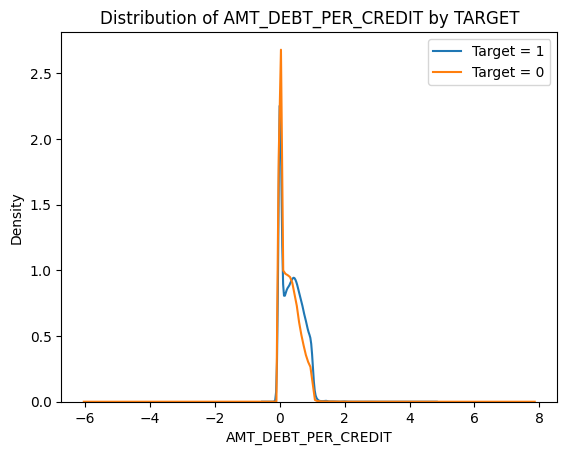

In [ ]:
## Keep plot for understanding feature
merged_data_train_for_plot = merged_data_train[(merged_data_train['AMT_DEBT_PER_CREDIT'] >= -20) & (merged_data_train['AMT_DEBT_PER_CREDIT'] <= 20)]
y = application_train['TARGET']
merged_data_train_for_plot['TARGET'] = y

for target_value in merged_data_train_for_plot['TARGET'].unique():
    sns.distplot(merged_data_train_for_plot[merged_data_train_for_plot['TARGET'] == target_value]['AMT_DEBT_PER_CREDIT'], label=f'Target = {target_value}', hist=False)

plt.title(f'Distribution of AMT_DEBT_PER_CREDIT by TARGET')
plt.legend()
plt.show()

In [ ]:
# merge data on test
merged_data_test = pd.merge(application_test_for_merge, prev_merge, on='SK_ID_CURR', how='left')
merged_data_test = pd.merge(merged_data_test, bureau_merge, on='SK_ID_CURR', how='left')

merged_data_train = merged_data_train.drop(columns=['SK_ID_CURR'])
merged_data_test = merged_data_test.drop(columns=['SK_ID_CURR'])

# ------------------------------------------------------------------------------------------------------

# Pre-process the merged data
col_num_fit = ['DAYS_TERMINATION', 'AMT_DEBT_PER_CREDIT']
col_cat_fit = ['NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Canceled',
               'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Unused offer',
               'NAME_YIELD_GROUP_XNA', 'NAME_YIELD_GROUP_high',
               'NAME_YIELD_GROUP_low_action', 'NAME_YIELD_GROUP_low_normal',
               'NAME_YIELD_GROUP_middle', 'HAVE_CREDIT_OVERDUE',
               'HAVE_CREDIT_PROLONG', 'HAVE_DAY_OVERDUE' ]
fit_all_cols = col_num_fit + col_cat_fit
all_cols_before_merge = [col for col in merged_data_train if col not in fit_all_cols]

# ------------------------------------------------------------------------------------------------------

# Fill in missing values
for col in col_num_fit:
    col_mean = merged_data_train[col].mean()
    merged_data_train[col] = merged_data_train[col].fillna(col_mean)
    merged_data_test[col] = merged_data_test[col].fillna(col_mean)

for col in col_cat_fit:
    mode_col = mode(merged_data_train[col].dropna())
    merged_data_train[col] = merged_data_train[col].fillna(mode_col)
    merged_data_test[col] = merged_data_test[col].fillna(mode_col)

# ------------------------------------------------------------------------------------------------------

# Numerical cols
merge_df_num_train = merged_data_train[col_num_fit]
merge_df_num_test = merged_data_test[col_num_fit]

merge_df_num_train = fix_outliers(merge_df_num_train, merge_df_num_train.columns)
merge_df_num_test = fix_outliers(merge_df_num_test, merge_df_num_test.columns)

scaler = MinMaxScaler()
merge_df_num_train = scaler.fit_transform(merge_df_num_train)
merge_df_num_test = scaler.transform(merge_df_num_test)

merge_df_num_train = pd.DataFrame(merge_df_num_train, columns=col_num_fit)
merge_df_num_test = pd.DataFrame(merge_df_num_test, columns=col_num_fit)

# ------------------------------------------------------------------------------------------------------

X_pd = pd.concat([merged_data_train[all_cols_before_merge], merged_data_train[col_cat_fit], merge_df_num_train], axis=1)
X_test_pd = pd.concat([merged_data_test[all_cols_before_merge], merged_data_test[col_cat_fit], merge_df_num_test], axis=1)

In [ ]:
!mkdir kaggle/data_prep

X_pd.to_csv('/content/kaggle/data_prep/X_pd.csv')
X_test_pd.to_csv('/content/kaggle/data_prep/X_test_pd.csv')

## Train test split

In [ ]:
# keep TARGET
y = application_train['TARGET']
y.shape

(307507,)

In [ ]:
# Clear system RAM
!rm home-credit-default-risk.zip

gc.collect()

83688

In [ ]:
# Clear system RAM
all_vars = %who_ls
selected_vars = [var for var in all_vars if isinstance(eval(var), (pd.DataFrame, list, np.ndarray, pd.Index, csr_matrix, float, str, range))]

for var in selected_vars:
    del globals()[var]

In [ ]:
# X_pd = pd.read_csv('/content/drive/MyDrive/X_pd.csv')
# X_test_pd = pd.read_csv('/content/drive/MyDrive/X_test_pd.csv')

X_pd = pd.read_csv('/content/kaggle/data_prep/X_pd.csv').drop(columns=['Unnamed: 0'])
X_test_pd = pd.read_csv('/content/kaggle/data_prep/X_test_pd.csv').drop(columns=['Unnamed: 0'])

In [ ]:
X_pd.shape, X_test_pd.shape

((307507, 159), (48744, 159))

In [ ]:
gc.collect()

7522

In [ ]:
# Train/Validation split
X_train_pd, X_val_pd, y_train, y_val = train_test_split(X_pd, y, test_size=0.2, stratify=y, random_state=0)

X_train_pd.reset_index(drop=True, inplace=True)
X_val_pd.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

In [ ]:
X_train_pd.shape, y_train.shape

((246005, 159), (246005,))

In [ ]:
X_val_pd.shape, y_val.shape

((61502, 159), (61502,))

In [ ]:
gc.collect()

0

# Model


## Description

**Main Idea**

The primary focus involves initially experimenting with various base models for binary classification, including:

- LightGBM
- Random Forest
- CatBoost
- Logistic Regression
- Decision Tree

The objective is to optimize each model by fine-tuning parameters and evaluating their individual performance.

Subsequently, ensemble technique like Stacking and AdaBoost will be applied to the models. This step aims to evaluate whether combining models can enhance the validation score.

Furthermore, the best-performing model will be subjected to testing with dimensionality reduction techniques, considering the abundance of features. This test aims to gauge the model's efficacy under reduced dimensions.

**Base Model Evaluation**

The following table shows the results of models with default parameters.

Models | Accuracy | F1-score | Recall | AUC |
--- | --- | --- | --- | ---
Logistic Regression | 0.693 | 0.264 | 0.682 | 0.748
Decision Tree | 0.857 | 0.152 | 0.159 | 0.539
Random Forest | 0.919 | 0.003 | 0.001 | 0.731
LightGBM | 0.702 | 0.269 | 0.680 | **0.757**
CatBoost | 0.750 | 0.283 | 0.611 | 0.752


Among all the models, LightGBM performed the best. On the other hand, the decision tree was overfitting due to the default parameter 'max_depth' being set to 'none'. This means that the model can create deeper depth without pruning, which leads to overfitting in the tree. Therefore, fine-tuning is a crucial step for this tree-based model.




**Fine-Tune Parameters**

Models | Accuracy | F1-score | Recall | AUC | Private Score | Public Score
--- | --- | --- | --- | --- | --- | ---
Decision Tree | 0.597 | 0.226 | 0.727 | 0.712 | 0.68667 | 0.69180
Random Forest | 0.729 | 0.272 | 0.626 | 0.744 | 0.73022 | 0.73239
LightGBM  | 0.705 | 0.271 | 0.678 | **0.758** | **0.74282** | **0.74889**
CatBoost  | 0.691 | 0.261 | 0.675 | 0.744 | 0.72338 | 0.73124


After fine-tuning the parameters, LightGBM demonstrated a better performance in terms of AUC. However, AUC for CatBoost is slightly lower than the base model due to the lower number of iterations and it is worth noting that the AUC on the test set was slightly lower than that of the validation set for all models. The models performed a bit lower with unseen data.


**Ensemble Models**

Models | Accuracy | F1-score | Recall | AUC | Private Score | Public Score
--- | --- | --- | --- | --- | --- | ---
Stacking | 0.677 | 0.258 | 0.697 | 0.749 | 0.73346 | 0.74221
AdaBoost with Logistic Regression | 0.693 | 0.263 | 0.681 | 0.748 | 0.73174 | 0.73960



In stacked generalization, I utilized a variety of high-performing models, including logistic regression and random forest, to create a combined model. This combined model was then used as input for the final estimator, which was LightGBM. By combining different models, the performance was not improved. Although the model outperformed logistic regression and random forest individually, it was slightly worse than LightGBM.

However, since the initial ensemble model might perform slightly worse than the best model (LightGBM), I also experimented with using AdaBoost. I chose logistic regression as the base estimator for its speed. Unfortunately, the performance of this model was not better.



**The Best Model**

At present, the most effective model is LightGBM, which is a gradient boosting framework that utilizes tree-based learning algorithms with optimal parameters such as learning_rate = 0.1, max_depth = 3, and n_estimators = 500. Keeping a small depth is advantageous as it helps avoid overfitting, which in turn helps the model to capture unseen data more accurately.

**Best Model with Dimensionality Reduction in Data**

As we possess a large dataset, we can acquire additional data from outsourcing such as bureau, bureau balance, credit card balance, installment payment, previous point of sales, cash loan balance, and previous application. In my experiment, I managed to gather only a few more features from the bureau and previous applications. It would be beneficial if I could obtain more valuable features that could enhance the model's performance. However, adding more features can increase computational costs. Therefore, data dimensionality reduction can be helpful when we have an abundance of data.


Models | Accuracy | F1-score | Recall | AUC | Private Score | Public Score
--- | --- | --- | --- | --- | --- | ---
PCA | 0.685 | 0.248 | 0.643 | 0.722 | 0.71157 | 0.70815
LDA | 0.676 | 0.258 | 0.699 | 0.745 | 0.72797 | 0.73848


Based on the table above, I conducted a PCA analysis using n_components that can keep the explained variance at 95%, and then trained the data using the best model (LightGBM). The test scores were found to be lower compared to the full data. Additionally, dimensionality reduction with LDA was also attempted but it performed better than PCA in terms of f1-score, recall, and AUC for both validation and test sets.



***Important Note and Limitation***

*   For the decision tree model, I used class_weight to handle the imbalanced data set. I tried using other techniques such as over-sampling and under-sampling, but setting class_weight gave the best performance out of the three techniques.

*   In my opinion, the current model's performance is still low, especially in terms of f1-score, making it less than ideal. I believe that the current models are not yet optimized to their fullest potential. To improve the fine-tuning parameters, we can add more parameters and widen the interval values. Additionally, we can use RandomizedSearchCV and set more n_iters with RepeatedStratifiedKFold and more n_repeats to find the optimal parameters.


***Future Work***

*   To improve the dataset, consider merging additional relevant data from supplementary tables.

*   For larger datasets, implementing dimensionality reduction techniques like LDA can help reduce the number of features while retaining valuable information.

*   To further optimize model performance, conduct more extensive parameter tuning.

*   To compare different models, exploring alternative models, such as neural networks, can help evaluate the efficacy compared to the current model.


## Logistic Regression

In [ ]:
class_weight = {0: 1, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}

clf = LogisticRegression(class_weight=class_weight, n_jobs=-1)

clf.fit(X_train_pd, y_train)

y_pred = clf.predict(X_val_pd)
y_pred_proba = clf.predict_proba(X_val_pd)[:, 1]

print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'f1_score: {f1_score(y_val, y_pred)}')
print(f'recall_score: {recall_score(y_val, y_pred)}')
print(f'AUC: {roc_auc_score(y_val, y_pred_proba)}')

class_report = classification_report(y_val, y_pred)
print(class_report)

Accuracy: 0.6930181132320901
f1_score: 0.2639950101356619
recall_score: 0.6819738167170192
AUC: 0.7478001884568245
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56537
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.69      0.54     61502
weighted avg       0.90      0.69      0.76     61502



Check important features ([source](https://forecastegy.com/posts/feature-importance-in-logistic-regression/))

In [ ]:
coefficients = clf.coef_[0]
abs_coefficients = np.abs(coefficients)

indices = np.argsort(abs_coefficients)[::-1]
feature_names = X_train_pd.columns

N = 10
print(f'Top {N} important features')
for i in range(N):
    print(f'{feature_names[indices[i]]}, {abs_coefficients[indices[i]]}')

Top 10 important features
EXT_SOURCE_3, 1.9742268691138747
EXT_SOURCE_2, 1.8234231303152535
DAYS_EMPLOYED, 0.7519009263334702
AMT_DEBT_PER_CREDIT, 0.7458099731237432
AMT_ANNUITY, 0.6489771753321356
ORGANIZATION_TYPE_Transport: type 3, 0.5929946080115422
ORGANIZATION_TYPE_Realtor, 0.47426753889639717
ORGANIZATION_TYPE_Trade: type 2, 0.4648669399971553
ORGANIZATION_TYPE_Military, 0.4357239445772256
NAME_EDUCATION_TYPE_Lower secondary, 0.35185611322095184


## Decision Tree

In [ ]:
# Weighted Decision tree
class_weight = {0: 1, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}
clf = DecisionTreeClassifier(class_weight=class_weight)

clf.fit(X_train_pd, y_train)

y_pred = clf.predict(X_val_pd)
y_pred_proba = clf.predict_proba(X_val_pd)[:, 1]

print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'f1_score: {f1_score(y_val, y_pred)}')
print(f'recall_score: {recall_score(y_val, y_pred)}')
print(f'AUC: {roc_auc_score(y_val, y_pred_proba)}')

class_report = classification_report(y_val, y_pred)
print(class_report)

Accuracy: 0.8574843094533511
f1_score: 0.1522390946900087
recall_score: 0.15850956696878146
AUC: 0.5386884287078727
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     56537
           1       0.15      0.16      0.15      4965

    accuracy                           0.86     61502
   macro avg       0.54      0.54      0.54     61502
weighted avg       0.86      0.86      0.86     61502



In [ ]:
class_weight = {0: 1, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}
model = DecisionTreeClassifier(class_weight=class_weight)

params = {'criterion': ['gini'],
          'max_depth': [5, 10, 15],
          'min_samples_split': [2, 5, 7] }

grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=5, verbose=1)

grid_search.fit(X_train_pd, y_train)

best_params = grid_search.best_params_
print(f'Best params: {best_params}')

clf = grid_search.best_estimator_

y_pred = clf.predict(X_val_pd)
y_pred_proba = clf.predict_proba(X_val_pd)[:, 1]

print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'f1_score: {f1_score(y_val, y_pred)}')
print(f'recall_score: {recall_score(y_val, y_pred)}')
print(f'AUC: {roc_auc_score(y_val, y_pred_proba)}')

class_report = classification_report(y_val, y_pred)
print(class_report)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Accuracy: 0.5970537543494521
f1_score: 0.22570767981003562
recall_score: 0.7274924471299093
AUC: 0.7117583168494619
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     56537
           1       0.13      0.73      0.23      4965

    accuracy                           0.60     61502
   macro avg       0.55      0.66      0.48     61502
weighted avg       0.89      0.60      0.69     61502



In [ ]:
# Gini importance

importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]
feature_names = X_train_pd.columns

N = 10
print(f'Top {N} important features')
for i in range(N):
    print(f'{feature_names[indices[i]]}, {abs_coefficients[indices[i]]}')

Top 10 important features
EXT_SOURCE_3, 1.9742268691138747
EXT_SOURCE_2, 1.8234231303152535
AGE, 0.30534215503922657
NAME_EDUCATION_TYPE_Higher education, 0.1062951379507787
CODE_GENDER_F, 0.09743303025926198
AMT_DEBT_PER_CREDIT, 0.7458099731237432
NAME_EDUCATION_TYPE_Secondary / secondary special, 0.22117275978285467
AMT_GOODS_PRICE, 0.2384257093835987
NAME_FAMILY_STATUS_Married, 0.07782437099825569
NAME_FAMILY_STATUS_Widow, 0.006530568945597157


In [ ]:
tree_text = export_text(clf, feature_names=list(X_train_pd.columns))
print(tree_text)

|--- EXT_SOURCE_3 <= 0.52
|   |--- EXT_SOURCE_2 <= 0.55
|   |   |--- EXT_SOURCE_3 <= 0.22
|   |   |   |--- EXT_SOURCE_2 <= 0.24
|   |   |   |   |--- EXT_SOURCE_3 <= 0.11
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- EXT_SOURCE_3 >  0.11
|   |   |   |   |   |--- class: 1
|   |   |   |--- EXT_SOURCE_2 >  0.24
|   |   |   |   |--- EXT_SOURCE_3 <= 0.08
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- EXT_SOURCE_3 >  0.08
|   |   |   |   |   |--- class: 1
|   |   |--- EXT_SOURCE_3 >  0.22
|   |   |   |--- EXT_SOURCE_2 <= 0.20
|   |   |   |   |--- AGE <= 0.60
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- AGE >  0.60
|   |   |   |   |   |--- class: 1
|   |   |   |--- EXT_SOURCE_2 >  0.20
|   |   |   |   |--- AGE <= 0.69
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- AGE >  0.69
|   |   |   |   |   |--- class: 1
|   |--- EXT_SOURCE_2 >  0.55
|   |   |--- EXT_SOURCE_3 <= 0.23
|   |   |   |--- AMT_DEBT_PER_CREDIT <= 0.64
|   |   |   |   |--- EXT_SOURCE_2 <= 0.74
|

## Random Forest

In [ ]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42)

clf.fit(X_train_pd, y_train)

y_pred = clf.predict(X_val_pd)
y_pred_proba = clf.predict_proba(X_val_pd)[:, 1]

print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'f1_score: {f1_score(y_val, y_pred)}')
print(f'recall_score: {recall_score(y_val, y_pred)}')
print(f'AUC: {roc_auc_score(y_val, y_pred_proba)}')

class_report = classification_report(y_val, y_pred)
print(class_report)

Accuracy: 0.9193034372865923
f1_score: 0.0028129395218002813
recall_score: 0.0014098690835850957
AUC: 0.7307683009714729
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.58      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.75      0.50      0.48     61502
weighted avg       0.89      0.92      0.88     61502



In [ ]:
params = {'n_estimators': [50, 100, 200],
          'criterion': ['gini'],
          'max_depth': [3, 5, 10, 15],
          'min_samples_split': randint(2, 10),
          'min_samples_leaf': randint(1, 10) }

model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)

random_search = RandomizedSearchCV(model, param_distributions=params,
                                   n_iter=3, scoring='roc_auc', cv=cv,
                                   random_state=42, n_jobs=-1)

random_res = random_search.fit(X_train_pd, y_train)

best_params = random_res.best_params_
print(f'Best Parameters: {best_params}')

clf = RandomForestClassifier(**best_params, class_weight='balanced', random_state=42, n_jobs=-1)

clf.fit(X_train_pd, y_train)

y_pred = clf.predict(X_val_pd)
y_pred_proba = clf.predict_proba(X_val_pd)[:, 1]

print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'f1_score: {f1_score(y_val, y_pred)}')
print(f'recall_score: {recall_score(y_val, y_pred)}')
print(f'AUC: {roc_auc_score(y_val, y_pred_proba)}')

class_report = classification_report(y_val, y_pred)
print(class_report)

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 200}
Accuracy: 0.729390914116614
f1_score: 0.2720552858330053
recall_score: 0.6263846928499497
AUC: 0.7439037017368392
              precision    recall  f1-score   support

           0       0.96      0.74      0.83     56537
           1       0.17      0.63      0.27      4965

    accuracy                           0.73     61502
   macro avg       0.57      0.68      0.55     61502
weighted avg       0.89      0.73      0.79     61502



In [ ]:
# Feature importance based on mean decrease in impurity

importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]
feature_names = X_train_pd.columns

N = 10
print(f'Top {N} important features')
for i in range(N):
    print(f'{feature_names[indices[i]]}, {abs_coefficients[indices[i]]}')

Top 10 important features
EXT_SOURCE_3, 1.9742268691138747
EXT_SOURCE_2, 1.8234231303152535
AMT_DEBT_PER_CREDIT, 0.7458099731237432
AGE, 0.30534215503922657
DAYS_EMPLOYED, 0.7519009263334702
DAYS_LAST_PHONE_CHANGE, 0.22225077468963164
AMT_GOODS_PRICE, 0.2384257093835987
NAME_CONTRACT_STATUS_Refused, 0.13437470334704846
DAYS_ID_PUBLISH, 0.27613429280955043
NAME_EDUCATION_TYPE_Higher education, 0.1062951379507787


## LGBM

In [ ]:
# change the column name if there are some special characters
X_train_pd_2 = X_train_pd.copy()
X_train_pd_2.columns = [re.sub('[^a-zA-Z0-9_]', '_', col) for col in X_train_pd_2.columns]

X_val_pd_2 = X_val_pd.copy()
X_val_pd_2.columns = [re.sub('[^a-zA-Z0-9_]', '_', col) for col in X_val_pd_2.columns]

In [ ]:
clf = LGBMClassifier(objective='binary', metric='auc', is_unbalance=True, random_state=42, force_col_wise=True, verbose=0)

clf.fit(X_train_pd_2, y_train)

y_pred = clf.predict(X_val_pd_2)
y_pred_proba = clf.predict_proba(X_val_pd_2)[:, 1]

print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'f1_score: {f1_score(y_val, y_pred)}')
print(f'recall_score: {recall_score(y_val, y_pred)}')
print(f'AUC: {roc_auc_score(y_val, y_pred_proba)}')

class_report = classification_report(y_val, y_pred)
print(class_report)

Accuracy: 0.7015381613606062
f1_score: 0.26886003345813747
recall_score: 0.6797583081570997
AUC: 0.7572436312905872
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56537
           1       0.17      0.68      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.56      0.69      0.54     61502
weighted avg       0.90      0.70      0.77     61502



In [ ]:
params = {'n_estimators': [10, 50, 100, 500],
          'learning_rate': [0.01, 0.1, 0.5],
          'max_depth': [3, 5, 10, 15] }

model = LGBMClassifier(objective='binary', metric='auc', is_unbalance=True, random_state=42, force_col_wise=True, verbose=-1)

grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='roc_auc')
grid_search.fit(X_train_pd_2, y_train)

best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

clf = grid_search.best_estimator_

y_pred = clf.predict(X_val_pd_2)
y_pred_proba = clf.predict_proba(X_val_pd_2)[:, 1]

print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'f1_score: {f1_score(y_val, y_pred)}')
print(f'recall_score: {recall_score(y_val, y_pred)}')
print(f'AUC: {roc_auc_score(y_val, y_pred_proba)}')

class_report = classification_report(y_val, y_pred)
print(class_report)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Accuracy: 0.7050339826347111
f1_score: 0.270713567839196
recall_score: 0.678147029204431
AUC: 0.7581390122815418
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56537
           1       0.17      0.68      0.27      4965

    accuracy                           0.71     61502
   macro avg       0.57      0.69      0.54     61502
weighted avg       0.90      0.71      0.77     61502



In [ ]:
# Feature importance

importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]
feature_names = X_train_pd.columns

N = 10
print(f'Top {N} important features')
for i in range(N):
    print(f'{feature_names[indices[i]]}, {abs_coefficients[indices[i]]}')

Top 10 important features
AMT_GOODS_PRICE, 0.2384257093835987
EXT_SOURCE_3, 1.9742268691138747
EXT_SOURCE_2, 1.8234231303152535
AGE, 0.30534215503922657
AMT_ANNUITY, 0.6489771753321356
REGION_POPULATION_RELATIVE, 0.13078827609057422
AMT_DEBT_PER_CREDIT, 0.7458099731237432
DAYS_REGISTRATION, 0.16490763800887348
DAYS_LAST_PHONE_CHANGE, 0.22225077468963164
DAYS_TERMINATION, 0.22534566855012872


Plot to see the performance

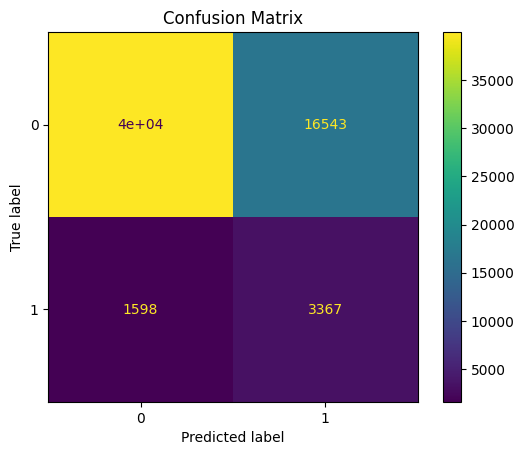

In [ ]:
cm = confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

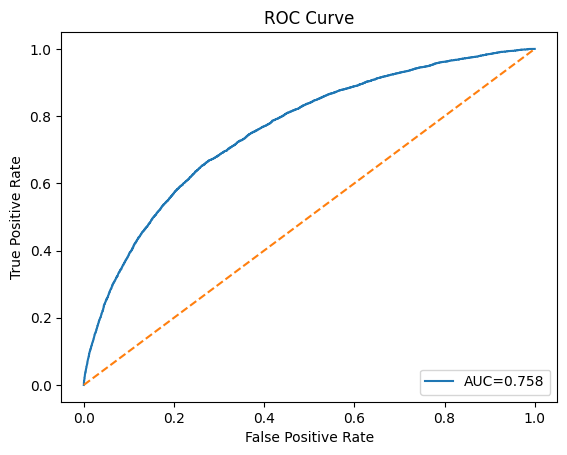

In [ ]:
fpr, tpr, _ = roc_curve(y_val,  y_pred_proba)
auc = roc_auc_score(y_val, y_pred_proba)

plt.plot(fpr, tpr, label=f'AUC={round(auc, 3)}')
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve')
plt.show()

## LightGBM (try)

In [ ]:
# params = {'n_estimators': [500, 1000],
#           'learning_rate': [0.1],
#           'max_depth': randint(3, 15),
#           'num_leaves': randint(20, 40)}

# model = LGBMClassifier(objective='binary', metric='auc', is_unbalance=True, random_state=42, force_col_wise=True, verbose=-1)
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

# random_search = RandomizedSearchCV(model, param_distributions=params,
#                                    n_iter=5, scoring='roc_auc', cv=cv,
#                                    random_state=42, n_jobs=-1)

# random_res = random_search.fit(X_train_pd_2, y_train)

# best_params = random_res.best_params_
# print(f'Best Parameters: {best_params}')

# clf = LGBMClassifier(**best_params, objective='binary', metric='auc', is_unbalance=True,
#                      random_state=42, force_col_wise=True, verbose=-1)


# clf.fit(X_train_pd_2, y_train)

# y_pred = clf.predict(X_val_pd_2)
# y_pred_proba = clf.predict_proba(X_val_pd_2)[:, 1]

# print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
# print(f'f1_score: {f1_score(y_val, y_pred)}')
# print(f'recall_score: {recall_score(y_val, y_pred)}')
# print(f'AUC: {roc_auc_score(y_val, y_pred_proba)}')

# class_report = classification_report(y_val, y_pred)
# print(class_report)


## CatBoost

[Source](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

In [ ]:
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

clf = CatBoostClassifier(scale_pos_weight = scale_pos_weight, verbose=0)

clf.fit(X_train_pd, y_train)

y_pred = clf.predict(X_val_pd)
y_pred_proba = clf.predict_proba(X_val_pd)[:, 1]

print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'f1_score: {f1_score(y_val, y_pred)}')
print(f'recall_score: {recall_score(y_val, y_pred)}')
print(f'AUC: {roc_auc_score(y_val, y_pred_proba)}')

class_report = classification_report(y_val, y_pred)
print(class_report)

Accuracy: 0.7502520243244122
f1_score: 0.2831139736768412
recall_score: 0.6108761329305136
AUC: 0.7518093944521106
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     56537
           1       0.18      0.61      0.28      4965

    accuracy                           0.75     61502
   macro avg       0.57      0.69      0.57     61502
weighted avg       0.89      0.75      0.80     61502



In [ ]:
params = {'depth': [3, 6, 10],
          'l2_leaf_reg': [1, 3, 5] }

scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
model = CatBoostClassifier(scale_pos_weight = scale_pos_weight, iterations=50, verbose=0)

grid_search = GridSearchCV(estimator=model,
                           param_grid=params,
                           scoring='roc_auc',
                           cv=3,
                           n_jobs=-1 )

grid_search.fit(X_train_pd, y_train)

best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

clf = grid_search.best_estimator_

y_pred = clf.predict(X_val_pd)
y_pred_proba = clf.predict_proba(X_val_pd)[:, 1]

print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'f1_score: {f1_score(y_val, y_pred)}')
print(f'recall_score: {recall_score(y_val, y_pred)}')
print(f'AUC: {roc_auc_score(y_val, y_pred_proba)}')

class_report = classification_report(y_val, y_pred)
print(class_report)

Best Parameters: {'depth': 10, 'l2_leaf_reg': 5}
Accuracy: 0.6911482553412898
f1_score: 0.2608086547067751
recall_score: 0.6749244712990936
AUC: 0.7435700575268723
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56537
           1       0.16      0.67      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.68      0.53     61502
weighted avg       0.90      0.69      0.76     61502



In [ ]:
# Feature importance

importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]
feature_names = X_train_pd.columns

N = 10
print(f'Top {N} important features')
for i in range(N):
    print(f'{feature_names[indices[i]]}, {abs_coefficients[indices[i]]}')

Top 10 important features
EXT_SOURCE_3, 1.9742268691138747
EXT_SOURCE_2, 1.8234231303152535
AMT_DEBT_PER_CREDIT, 0.7458099731237432
AGE, 0.30534215503922657
DAYS_EMPLOYED, 0.7519009263334702
NAME_CONTRACT_STATUS_Refused, 0.13437470334704846
NAME_EDUCATION_TYPE_Higher education, 0.1062951379507787
CODE_GENDER_M, 0.27120310968549
CODE_GENDER_F, 0.09743303025926198
NAME_EDUCATION_TYPE_Secondary / secondary special, 0.22117275978285467


## Ensemble models

In [ ]:
cw = {0: 1, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}
lr = LogisticRegression(class_weight=cw, n_jobs=-1)

best_params_rf = {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 200}
rf = RandomForestClassifier(**best_params_rf, class_weight='balanced', random_state=42, n_jobs=-1)

best_params_lgbm = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
lgbm = LGBMClassifier(**best_params_lgbm,
                      objective='binary', metric='auc', is_unbalance=True, random_state=42, force_col_wise=True, verbose=-1)

estimators = [('lr', lr), ('rf', rf)]

clf = StackingClassifier(estimators=estimators, final_estimator=lgbm)

clf.fit(X_train_pd, y_train)

y_pred = clf.predict(X_val_pd)
y_pred_proba = clf.predict_proba(X_val_pd)[:, 1]

print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'f1_score: {f1_score(y_val, y_pred)}')
print(f'recall_score: {recall_score(y_val, y_pred)}')
print(f'AUC: {roc_auc_score(y_val, y_pred_proba)}')

class_report = classification_report(y_val, y_pred)
print(class_report)

Accuracy: 0.6769048161035414
f1_score: 0.2583510618445116
recall_score: 0.697079556898288
AUC: 0.7486500093576486
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56537
           1       0.16      0.70      0.26      4965

    accuracy                           0.68     61502
   macro avg       0.56      0.69      0.53     61502
weighted avg       0.90      0.68      0.75     61502



In [ ]:
cw = {0: 1, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}
lr = LogisticRegression(class_weight=cw, n_jobs=-1)

clf = AdaBoostClassifier(base_estimator=lr, n_estimators=500, random_state=42)

clf.fit(X_train_pd, y_train)

y_pred = clf.predict(X_val_pd)
y_pred_proba = clf.predict_proba(X_val_pd)[:, 1]

print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'f1_score: {f1_score(y_val, y_pred)}')
print(f'recall_score: {recall_score(y_val, y_pred)}')
print(f'AUC: {roc_auc_score(y_val, y_pred_proba)}')

class_report = classification_report(y_val, y_pred)
print(class_report)


Accuracy: 0.6928229976260935
f1_score: 0.26346978557504874
recall_score: 0.6805639476334341
AUC: 0.7479831413060499
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56537
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.69      0.53     61502
weighted avg       0.90      0.69      0.76     61502



## Dimensional Reduction

### LDA

In [ ]:
lda = LinearDiscriminantAnalysis()

X_train_lda = lda.fit_transform(X_train_pd, y_train)

X_val_lda = lda.transform(X_val_pd)
X_test_lda = lda.transform(X_test_pd)

### PCA

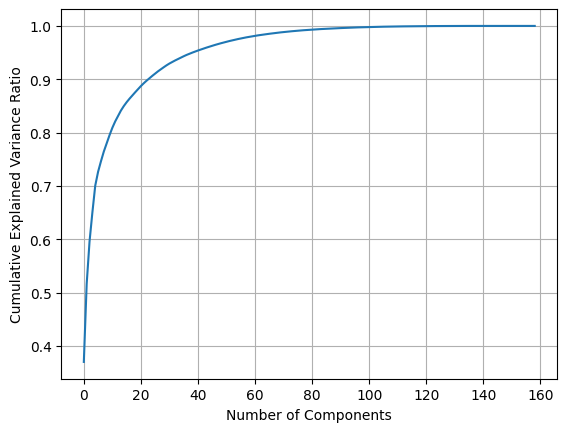

In [ ]:
pca = PCA()
pca.fit(X_train_pd)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [ ]:
n_95 = np.argmax(cumsum >= 0.95)
n_95, cumsum[n_95]

(39, 0.951971097162895)

In [ ]:
pca = PCA(n_components=n_95)
pca.fit(X_train_pd)

X_train_pca = pca.transform(X_train_pd)
X_val_pca = pca.transform(X_val_pd)
X_test_pca = pca.transform(X_test_pd)

### Test Model

In [ ]:
# Best model with LGBMClassifier and PCA
best_params_lgbm = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
clf = LGBMClassifier(**best_params_lgbm, objective='binary', metric='auc', is_unbalance=True, random_state=42, force_col_wise=True, verbose=-1)

clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_val_pca)
y_pred_proba = clf.predict_proba(X_val_pca)[:, 1]

print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'f1_score: {f1_score(y_val, y_pred)}')
print(f'recall_score: {recall_score(y_val, y_pred)}')
print(f'AUC: {roc_auc_score(y_val, y_pred_proba)}')

class_report = classification_report(y_val, y_pred)
print(class_report)

Accuracy: 0.6849858541185653
f1_score: 0.2479037267080745
recall_score: 0.6431017119838872
AUC: 0.7219750022982213
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56537
           1       0.15      0.64      0.25      4965

    accuracy                           0.68     61502
   macro avg       0.56      0.67      0.52     61502
weighted avg       0.89      0.68      0.76     61502



In [ ]:
# Best model with LGBMClassifier and LDA
best_params_lgbm = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
clf = LGBMClassifier(**best_params_lgbm, objective='binary', metric='auc', is_unbalance=True, random_state=42, force_col_wise=True, verbose=-1)

clf.fit(X_train_lda, y_train)
y_pred = clf.predict(X_val_lda)
y_pred_proba = clf.predict_proba(X_val_lda)[:, 1]

print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'f1_score: {f1_score(y_val, y_pred)}')
print(f'recall_score: {recall_score(y_val, y_pred)}')
print(f'AUC: {roc_auc_score(y_val, y_pred_proba)}')

class_report = classification_report(y_val, y_pred)
print(class_report)

Accuracy: 0.6761731325810543
f1_score: 0.2583600208535042
recall_score: 0.6986908358509567
AUC: 0.7453303837725995
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56537
           1       0.16      0.70      0.26      4965

    accuracy                           0.68     61502
   macro avg       0.56      0.69      0.53     61502
weighted avg       0.90      0.68      0.75     61502



# Submit Test Result to Kaggle

This part is for predicting probability in the test set and then submitting it in Kaggle. Please make sure that you've already changed the test data and file name before running.

In [ ]:
test_idx_keep = pd.read_csv('/content/kaggle/dataset/application_test.csv')
idx_test_submit = test_idx_keep['SK_ID_CURR']

In [ ]:
y_pred_test_proba = clf.predict_proba(X_test_pd)[:, 1]

In [ ]:
df_submit = pd.DataFrame({'SK_ID_CURR': idx_test_submit, 'TARGET': y_pred_test_proba})
df_submit.to_csv('Re_CAT2.csv', index=False)

In [ ]:
!kaggle competitions submit -c home-credit-default-risk -f /content/Re_CAT2.csv -m "Re_CAT2"

100% 1.22M/1.22M [00:01<00:00, 785kB/s] 
Successfully submitted to Home Credit Default Risk